In [391]:
import os
import numpy as np
import csv
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter
import math
import time
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.layers import GRU, LSTM, Bidirectional, Dense, Flatten, Conv1D, BatchNormalization, LeakyReLU, Dropout
from tensorflow.keras import Sequential
from keras.utils import plot_model
from sklearn.metrics import mean_squared_error
from tqdm import tqdm
import statsmodels.api as sm
from math import sqrt
from datetime import datetime, timedelta
from sklearn.preprocessing import MinMaxScaler
from pickle import dump
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import unicodedata
import pydot
import warnings
warnings.filterwarnings("ignore")



In [392]:
stock_name = 'AMZN'
stock_name_test = 'TSLA'

In [393]:
tweets = pd.read_csv('stock_tweets.csv')

In [394]:
print(tweets.shape)
tweets.head()

(80793, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [395]:
df = tweets[tweets['Stock Name'] == stock_name]
df_testing = tweets[tweets['Stock Name'] == stock_name_test]
print(df.shape)
df.head()
df_testing.head()

(4089, 4)


,Date,Tweet,Stock Name,Company Name
0,2022-09-29 23:41:16+00:00,Mainstream media has done an amazing job at br...,TSLA,"Tesla, Inc."
1,2022-09-29 23:24:43+00:00,Tesla delivery estimates are at around 364k fr...,TSLA,"Tesla, Inc."
2,2022-09-29 23:18:08+00:00,3/ Even if I include 63.0M unvested RSUs as of...,TSLA,"Tesla, Inc."
3,2022-09-29 22:40:07+00:00,@RealDanODowd @WholeMarsBlog @Tesla Hahaha why...,TSLA,"Tesla, Inc."
4,2022-09-29 22:27:05+00:00,"@RealDanODowd @Tesla Stop trying to kill kids,...",TSLA,"Tesla, Inc."


In [396]:
sent_df = df.copy()
sent_df["sentiment_score"] = ''
sent_df["Negative"] = ''
sent_df["Neutral"] = ''
sent_df["Positive"] = ''
sent_df.head()

sent_df_2 = df_testing.copy()
sent_df_2["sentiment_score"] = ''
sent_df_2["Negative"] = ''
sent_df_2["Neutral"] = ''
sent_df_2["Positive"] = ''
sent_df_2.columns

Index(['Date', 'Tweet', 'Stock Name', 'Company Name', 'sentiment_score',
       'Negative', 'Neutral', 'Positive'],
      dtype='object')

In [397]:
import nltk
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\zenil\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [398]:
%%time
sentiment_analyzer = SentimentIntensityAnalyzer()

def get_sentiment_score(sentence):
    sentence_i = unicodedata.normalize('NFKD', sentence)
    sentence_sentiment = sentiment_analyzer.polarity_scores(sentence_i)
    return sentence_sentiment['compound']

sent_df['sentiment_score'] = sent_df['Tweet'].apply(get_sentiment_score)
sent_df_2['sentiment_score'] = sent_df_2['Tweet'].apply(get_sentiment_score)
sent_df_2.columns


In [ ]:
sent_df.head()
sent_df_2.columns

Index(['Date', 'Tweet', 'Stock Name', 'Company Name', 'sentiment_score',
       'Negative', 'Neutral', 'Positive'],
      dtype='object')

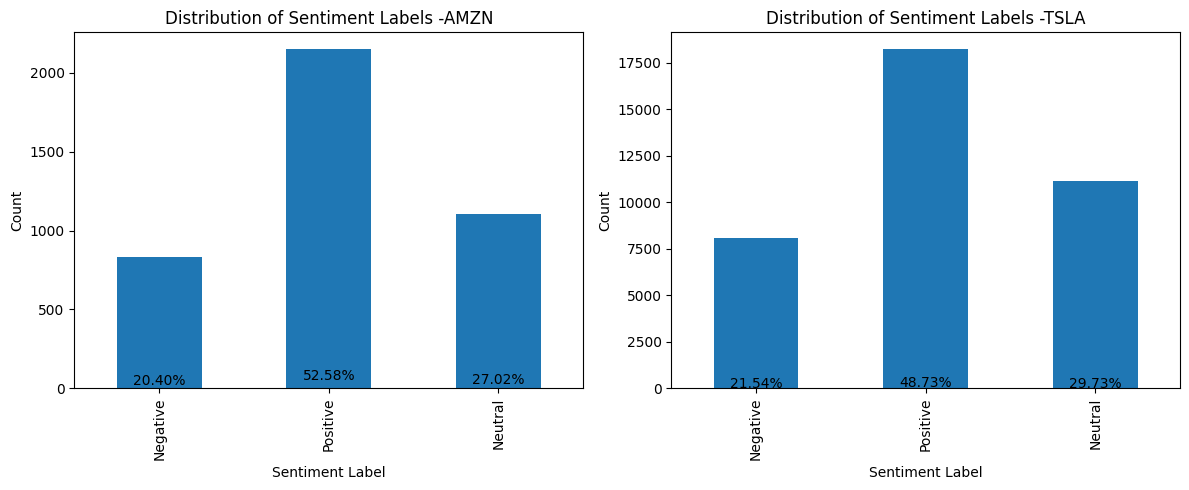

In [ ]:
sentiment_analyzer = SentimentIntensityAnalyzer()

def get_sentiment_label(score):
    if score >= 0.05:
        return "Positive"
    elif score <= -0.05:
        return "Negative"
    else:
        return "Neutral"

def analyze_sentiments(sent_df):
    sent_df['sentiment_score'] = sent_df['Tweet'].apply(lambda x: sentiment_analyzer.polarity_scores(unicodedata.normalize('NFKD', x))['compound'])
    sent_df['sentiment_label'] = sent_df['sentiment_score'].apply(get_sentiment_label)
    return sent_df

sent_df = analyze_sentiments(sent_df)
sent_df_2 = analyze_sentiments(sent_df_2)

fig, (ax, bx) = plt.subplots(1, 2, figsize=(12, 5))
sent_df['sentiment_label'].value_counts().reindex(['Negative', 'Positive', 'Neutral']).plot(kind='bar', ax=ax)
ax.set_title('Distribution of Sentiment Labels -' f'{stock_name}')
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')

total_samples_df1 = len(sent_df)
percentage_df1 = sent_df['sentiment_label'].value_counts(normalize=True).reindex(['Negative', 'Positive', 'Neutral']) * 100

for i, v in enumerate(percentage_df1):
    ax.text(i, v + 1, f'{v:.2f}%', ha='center')

sent_df_2['sentiment_label'].value_counts().reindex(['Negative', 'Positive', 'Neutral']).plot(kind='bar', ax=bx)
bx.set_title('Distribution of Sentiment Labels -' f'{stock_name_test}')
bx.set_xlabel('Sentiment Label')
bx.set_ylabel('Count')

total_samples_df2 = len(sent_df_2)
percentage_df2 = sent_df_2['sentiment_label'].value_counts(normalize=True).reindex(['Negative', 'Positive', 'Neutral']) * 100

for i, v in enumerate(percentage_df2):
    bx.text(i, v + 1, f'{v:.2f}%', ha='center')

plt.tight_layout()
plt.show()


Tweet, sentiment_score = list(sent_df['Tweet']), list(sent_df['sentiment_score'])
Tweet_2, sentiment_score_2 = list(sent_df_2['Tweet']), list(sent_df_2['sentiment_score'])


In [ ]:
print(df)

                            Date  \
48351  2022-09-29 22:40:47+00:00   
48352  2022-09-29 22:23:54+00:00   
48353  2022-09-29 18:34:51+00:00   
48354  2022-09-29 15:57:59+00:00   
48355  2022-09-29 15:10:30+00:00   
...                          ...   
52435  2021-09-30 20:50:16+00:00   
52436  2021-09-30 19:45:13+00:00   
52437  2021-09-30 18:01:19+00:00   
52438  2021-09-30 17:56:14+00:00   
52439  2021-09-30 01:59:22+00:00   

                                                   Tweet Stock Name  \
48351  A group of lawmakers led by Sen. Elizabeth War...       AMZN   
48352  $NIO just because I'm down money doesn't mean ...       AMZN   
48353  Today’s drop in $SPX is a perfect example of w...       AMZN   
48354  Druckenmiller owned $CVNA this year \nMunger b...       AMZN   
48355  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...       AMZN   
...                                                  ...        ...   
52435  My top 10 holdings make up 66% of my portfolio...       AMZN   

In [ ]:
sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df_2['Date'] = pd.to_datetime(sent_df_2['Date'])
sent_df['Date'] = sent_df['Date'].dt.date
sent_df_2['Date'] = sent_df_2['Date'].dt.date
sent_df = sent_df.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])
sent_df_2 = sent_df_2.drop(columns=['Negative', 'Positive', 'Neutral', 'Stock Name', 'Company Name'])

print(sent_df.head())

             Date                                              Tweet  \
48351  2022-09-29  A group of lawmakers led by Sen. Elizabeth War...   
48352  2022-09-29  $NIO just because I'm down money doesn't mean ...   
48353  2022-09-29  Today’s drop in $SPX is a perfect example of w...   
48354  2022-09-29  Druckenmiller owned $CVNA this year \nMunger b...   
48355  2022-09-29  Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...   

       sentiment_score sentiment_label  
48351          -0.0772        Negative  
48352           0.2500        Positive  
48353          -0.3182        Negative  
48354           0.2382        Positive  
48355           0.7783        Positive  


In [ ]:
print(sent_df.columns)
sent_df['sentiment_label'] = sent_df['sentiment_label'].apply(lambda x: 1 if x == 'Positive' else 0 if x == 'Neutral' else -1)
sent_df_2['sentiment_label'] = sent_df_2['sentiment_label'].apply(lambda x: 1 if x == 'Positive' else 0 if x == 'Neutral' else -1)
print(sent_df_2.columns)
sent_df.head()

Index(['Date', 'Tweet', 'sentiment_score', 'sentiment_label'], dtype='object')
Index(['Date', 'Tweet', 'sentiment_score', 'sentiment_label'], dtype='object')


,Date,Tweet,sentiment_score,sentiment_label
48351,2022-09-29,A group of lawmakers led by Sen. Elizabeth War...,-0.0772,-1
48352,2022-09-29,$NIO just because I'm down money doesn't mean ...,0.2500,1
48353,2022-09-29,Today’s drop in $SPX is a perfect example of w...,-0.3182,-1
48354,2022-09-29,Druckenmiller owned $CVNA this year \nMunger b...,0.2382,1
48355,2022-09-29,Top 10 $QQQ Holdings \n\nAnd Credit Rating\n\n...,0.7783,1


In [ ]:
print(sent_df.columns)
print(sent_df_2.columns)

sent_df['Date'] = pd.to_datetime(sent_df['Date'])
sent_df.set_index('Date', inplace=True)

sent_df_2['Date'] = pd.to_datetime(sent_df_2['Date'])
sent_df_2.set_index('Date', inplace=True)

def mode_aggregation(series):
    return series.mode().iloc[0]

twitter_df = sent_df.groupby(sent_df.index).agg({
    'sentiment_score': 'mean',
    'sentiment_label': mode_aggregation
})

twitter_df_2 = sent_df_2.groupby(sent_df_2.index).agg({
    'sentiment_score': 'mean',
    'sentiment_label': mode_aggregation
})

twitter_df.reset_index(inplace=True)
twitter_df_2.reset_index(inplace=True)

print(twitter_df)


Index(['Date', 'Tweet', 'sentiment_score', 'sentiment_label'], dtype='object')
Index(['Date', 'Tweet', 'sentiment_score', 'sentiment_label'], dtype='object')
          Date  sentiment_score  sentiment_label
0   2021-09-30         0.246480                1
1   2021-10-01         0.359337                1
2   2021-10-02        -0.000700                1
3   2021-10-03         0.834400                1
4   2021-10-04         0.258650                1
..         ...              ...              ...
360 2022-09-25         0.225867                1
361 2022-09-26        -0.068714               -1
362 2022-09-27        -0.096700               -1
363 2022-09-28         0.394520                1
364 2022-09-29         0.117650                1

[365 rows x 3 columns]


In [ ]:
twitter_df.columns

Index(['Date', 'sentiment_score', 'sentiment_label'], dtype='object')

In [ ]:
stocks = pd.read_csv('stock_yfinance_data.csv')
print(stocks.shape)
stocks.head()
sent_df['sentiment_label']

(6300, 8)


Date
2022-09-29   -1
2022-09-29    1
2022-09-29   -1
2022-09-29    1
2022-09-29    1
             ..
2021-09-30    1
2021-09-30   -1
2021-09-30   -1
2021-09-30    1
2021-09-30    1
Name: sentiment_label, Length: 4089, dtype: int64

In [ ]:
stock_df = stocks[stocks['Stock Name'] == stock_name]
stock_df_2 = stocks[stocks['Stock Name'] == stock_name_test]
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
stock_df_2['Date'] = pd.to_datetime(stock_df_2['Date'])
stock_df['Date'] = stock_df['Date'].dt.date
stock_df_2['Date'] = stock_df_2['Date'].dt.date
print(twitter_df.columns)

Index(['Date', 'sentiment_score', 'sentiment_label'], dtype='object')


In [ ]:
stock_df['Date'] = pd.to_datetime(stock_df['Date'])
twitter_df['Date'] = pd.to_datetime(twitter_df['Date'])

stock_df_2['Date'] = pd.to_datetime(stock_df_2['Date'])
twitter_df_2['Date'] = pd.to_datetime(twitter_df_2['Date'])

# Perform the join operation
final_df = stock_df.join(twitter_df.set_index('Date'), on='Date')
final_df = final_df.drop(columns=['Stock Name'])

final_df_2 = stock_df_2.join(twitter_df_2.set_index('Date'), on='Date')
final_df_2 = final_df_2.drop(columns=['Stock Name'])

print(final_df.head())
print(final_df_2.head())

           Date        Open        High         Low       Close   Adj Close  \
1008 2021-09-30  165.800003  166.392502  163.699493  164.251999  164.251999   
1009 2021-10-01  164.450500  165.458496  162.796997  164.162994  164.162994   
1010 2021-10-04  163.969498  163.999496  158.812500  159.488998  159.488998   
1011 2021-10-05  160.225006  163.036499  160.123001  161.050003  161.050003   
1012 2021-10-06  160.676498  163.216995  159.931000  163.100494  163.100494   

        Volume  sentiment_score  sentiment_label  
1008  56848000         0.246480                1  
1009  56712000         0.359337                1  
1010  90462000         0.258650                1  
1011  65384000         0.045500                1  
1012  50660000         0.194300                1  
        Date        Open        High         Low       Close   Adj Close  \
0 2021-09-30  260.333344  263.043335  258.333344  258.493347  258.493347   
1 2021-10-01  259.466675  260.260010  254.529999  258.406677  258.4

In [ ]:
final_df.head()

,Date,Open,High,Low,Close,Adj Close,Volume,sentiment_score,sentiment_label
1008,2021-09-30,165.800003,166.392502,163.699493,164.251999,164.251999,56848000,0.246480,1
1009,2021-10-01,164.450500,165.458496,162.796997,164.162994,164.162994,56712000,0.359337,1
1010,2021-10-04,163.969498,163.999496,158.812500,159.488998,159.488998,90462000,0.258650,1
1011,2021-10-05,160.225006,163.036499,160.123001,161.050003,161.050003,65384000,0.045500,1
1012,2021-10-06,160.676498,163.216995,159.931000,163.100494,163.100494,50660000,0.194300,1


Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'sentiment_score', 'sentiment_label'],
      dtype='object')

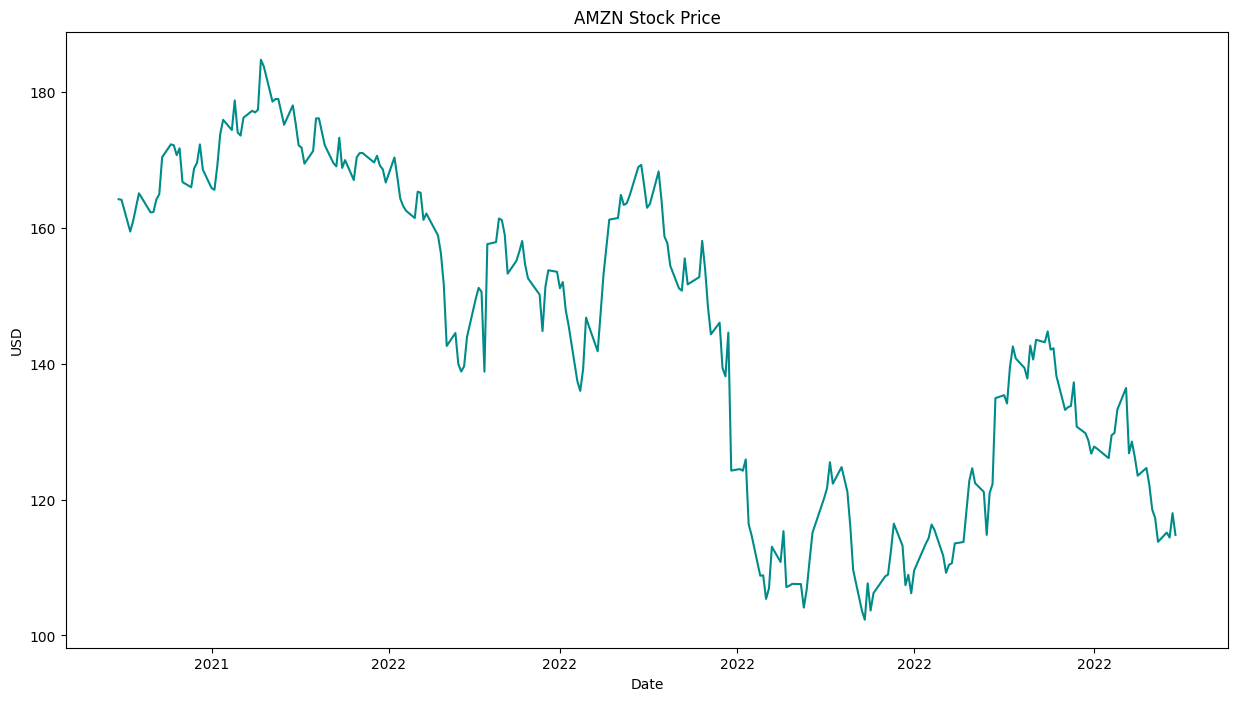

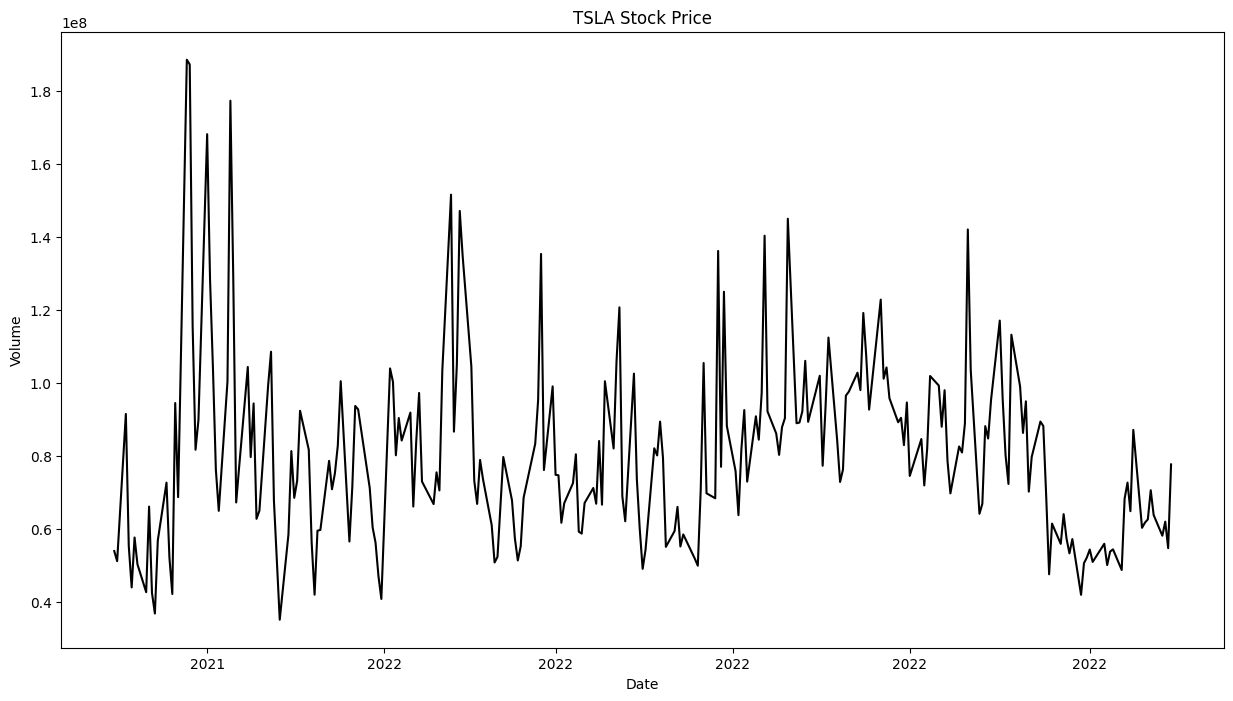

In [ ]:
fig, ax = plt.subplots(figsize=(15,8))
print(final_df.columns)
ax.plot(final_df['Date'], final_df['Close'], color='#008B8B')
ax.set(xlabel="Date", ylabel="USD", title=f"{stock_name} Stock Price")
ax.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()

fig, bx = plt.subplots(figsize=(15,8))
bx.plot(final_df_2['Date'], final_df_2['Volume'], color='#000000')
bx.set(xlabel="Date", ylabel="Volume", title=f"{stock_name_test} Stock Price")
bx.xaxis.set_major_formatter(DateFormatter("%Y"))
plt.show()


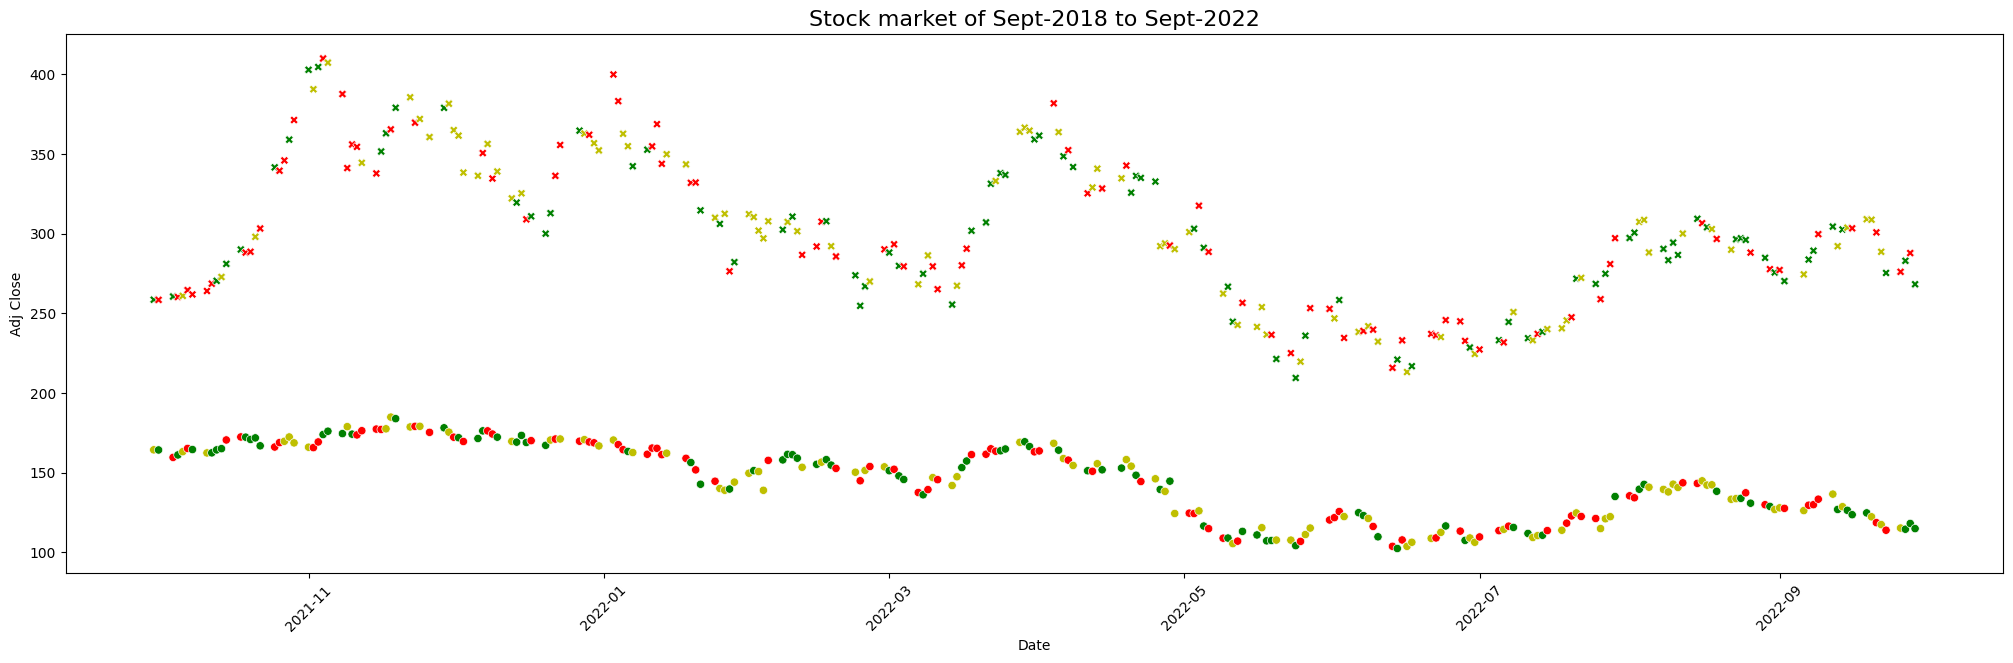

In [ ]:
final_df['dataset'] = 'final_df'
final_df_2['dataset'] = 'final_df_2'

combined_df = pd.concat([final_df, final_df_2])

fig, ax = plt.subplots(figsize=(25, 7))

sns.scatterplot(x='Date', y='Adj Close', data=combined_df, hue='sentiment_score', palette=['y', 'r', 'g'], style='dataset', ax=ax, legend=False)
plt.xticks(rotation=45)
plt.title("Stock market of Sept-2018 to Sept-2022", fontsize=16)

plt.show()

In [ ]:
def get_tech_ind(data):
    data['MA7'] = data.iloc[:,4].rolling(window=7).mean()
    data['MA20'] = data.iloc[:,4].rolling(window=20).mean()

    data['MACD'] = data.iloc[:,4].ewm(span=26).mean() - data.iloc[:,1].ewm(span=12,adjust=False).mean()

    data['20SD'] = data.iloc[:, 4].rolling(20).std()
    data['upper_band'] = data['MA20'] + (data['20SD'] * 2)
    data['lower_band'] = data['MA20'] - (data['20SD'] * 2)

    data['EMA'] = data.iloc[:,4].ewm(com=0.5).mean()
    
    data['logmomentum'] = np.log(data.iloc[:,4] - 1)

    return data

In [ ]:
tech_df = get_tech_ind(final_df)
tech_df_2 = get_tech_ind(final_df_2)
dataset = tech_df.iloc[20:,:].reset_index(drop=True)
dataset_2 = tech_df_2.iloc[20:,:].reset_index(drop=True)
# drop Date column
dataset = dataset.drop(columns=["Date"])
dataset_2 = dataset_2.drop(columns=["Date"])
dataset.head()
dataset_2.head()

,Open,High,Low,Close,Adj Close,Volume,sentiment_score,sentiment_label,dataset,MA7,MA20,MACD,20SD,upper_band,lower_band,EMA,logmomentum
0,356.103333,360.333344,351.399994,359.013336,359.013336,81639600,0.185287,1,final_df_2,325.127141,288.855501,-9.269895,32.580099,354.015698,223.695304,353.510805,5.880570
1,360.619995,371.736664,357.736664,371.333344,371.333344,89755200,0.147279,1,final_df_2,336.946189,294.501834,-10.609662,36.566908,367.635649,221.368019,365.392497,5.914404
2,381.666656,403.250000,372.886658,402.863342,402.863342,168146100,0.211411,1,final_df_2,351.926666,301.619501,-11.860446,42.906989,387.433479,215.805523,390.373061,5.996112
3,386.453339,402.863342,382.000000,390.666656,390.666656,128213400,0.155453,1,final_df_2,364.418095,308.143001,-14.295169,46.078655,400.300312,215.985690,390.568791,5.965292
4,392.443329,405.130005,384.206665,404.619995,404.619995,103885500,0.147228,1,final_df_2,373.418095,315.328168,-15.716662,49.410503,414.149173,216.507162,399.936260,6.000474


In [ ]:
def tech_ind(dataset):
    fig,ax = plt.subplots(figsize=(15, 8), dpi = 200)
    x_ = range(3, dataset.shape[0])
    x_ = list(dataset.index)

    ax.plot(dataset['Date'], dataset['MA7'], label='Moving Average (7 days)', color='g', linestyle='--')
    ax.plot(dataset['Date'], dataset['Close'], label='Closing Price', color='#6A5ACD')
    ax.plot(dataset['Date'], dataset['MA20'], label='Moving Average (20 days)', color='r', linestyle='-.')
    ax.xaxis.set_major_formatter(DateFormatter("%Y"))
    plt.title('Technical indicators')
    plt.ylabel('Close (USD)')
    plt.xlabel("Year")
    plt.legend()

    plt.show()

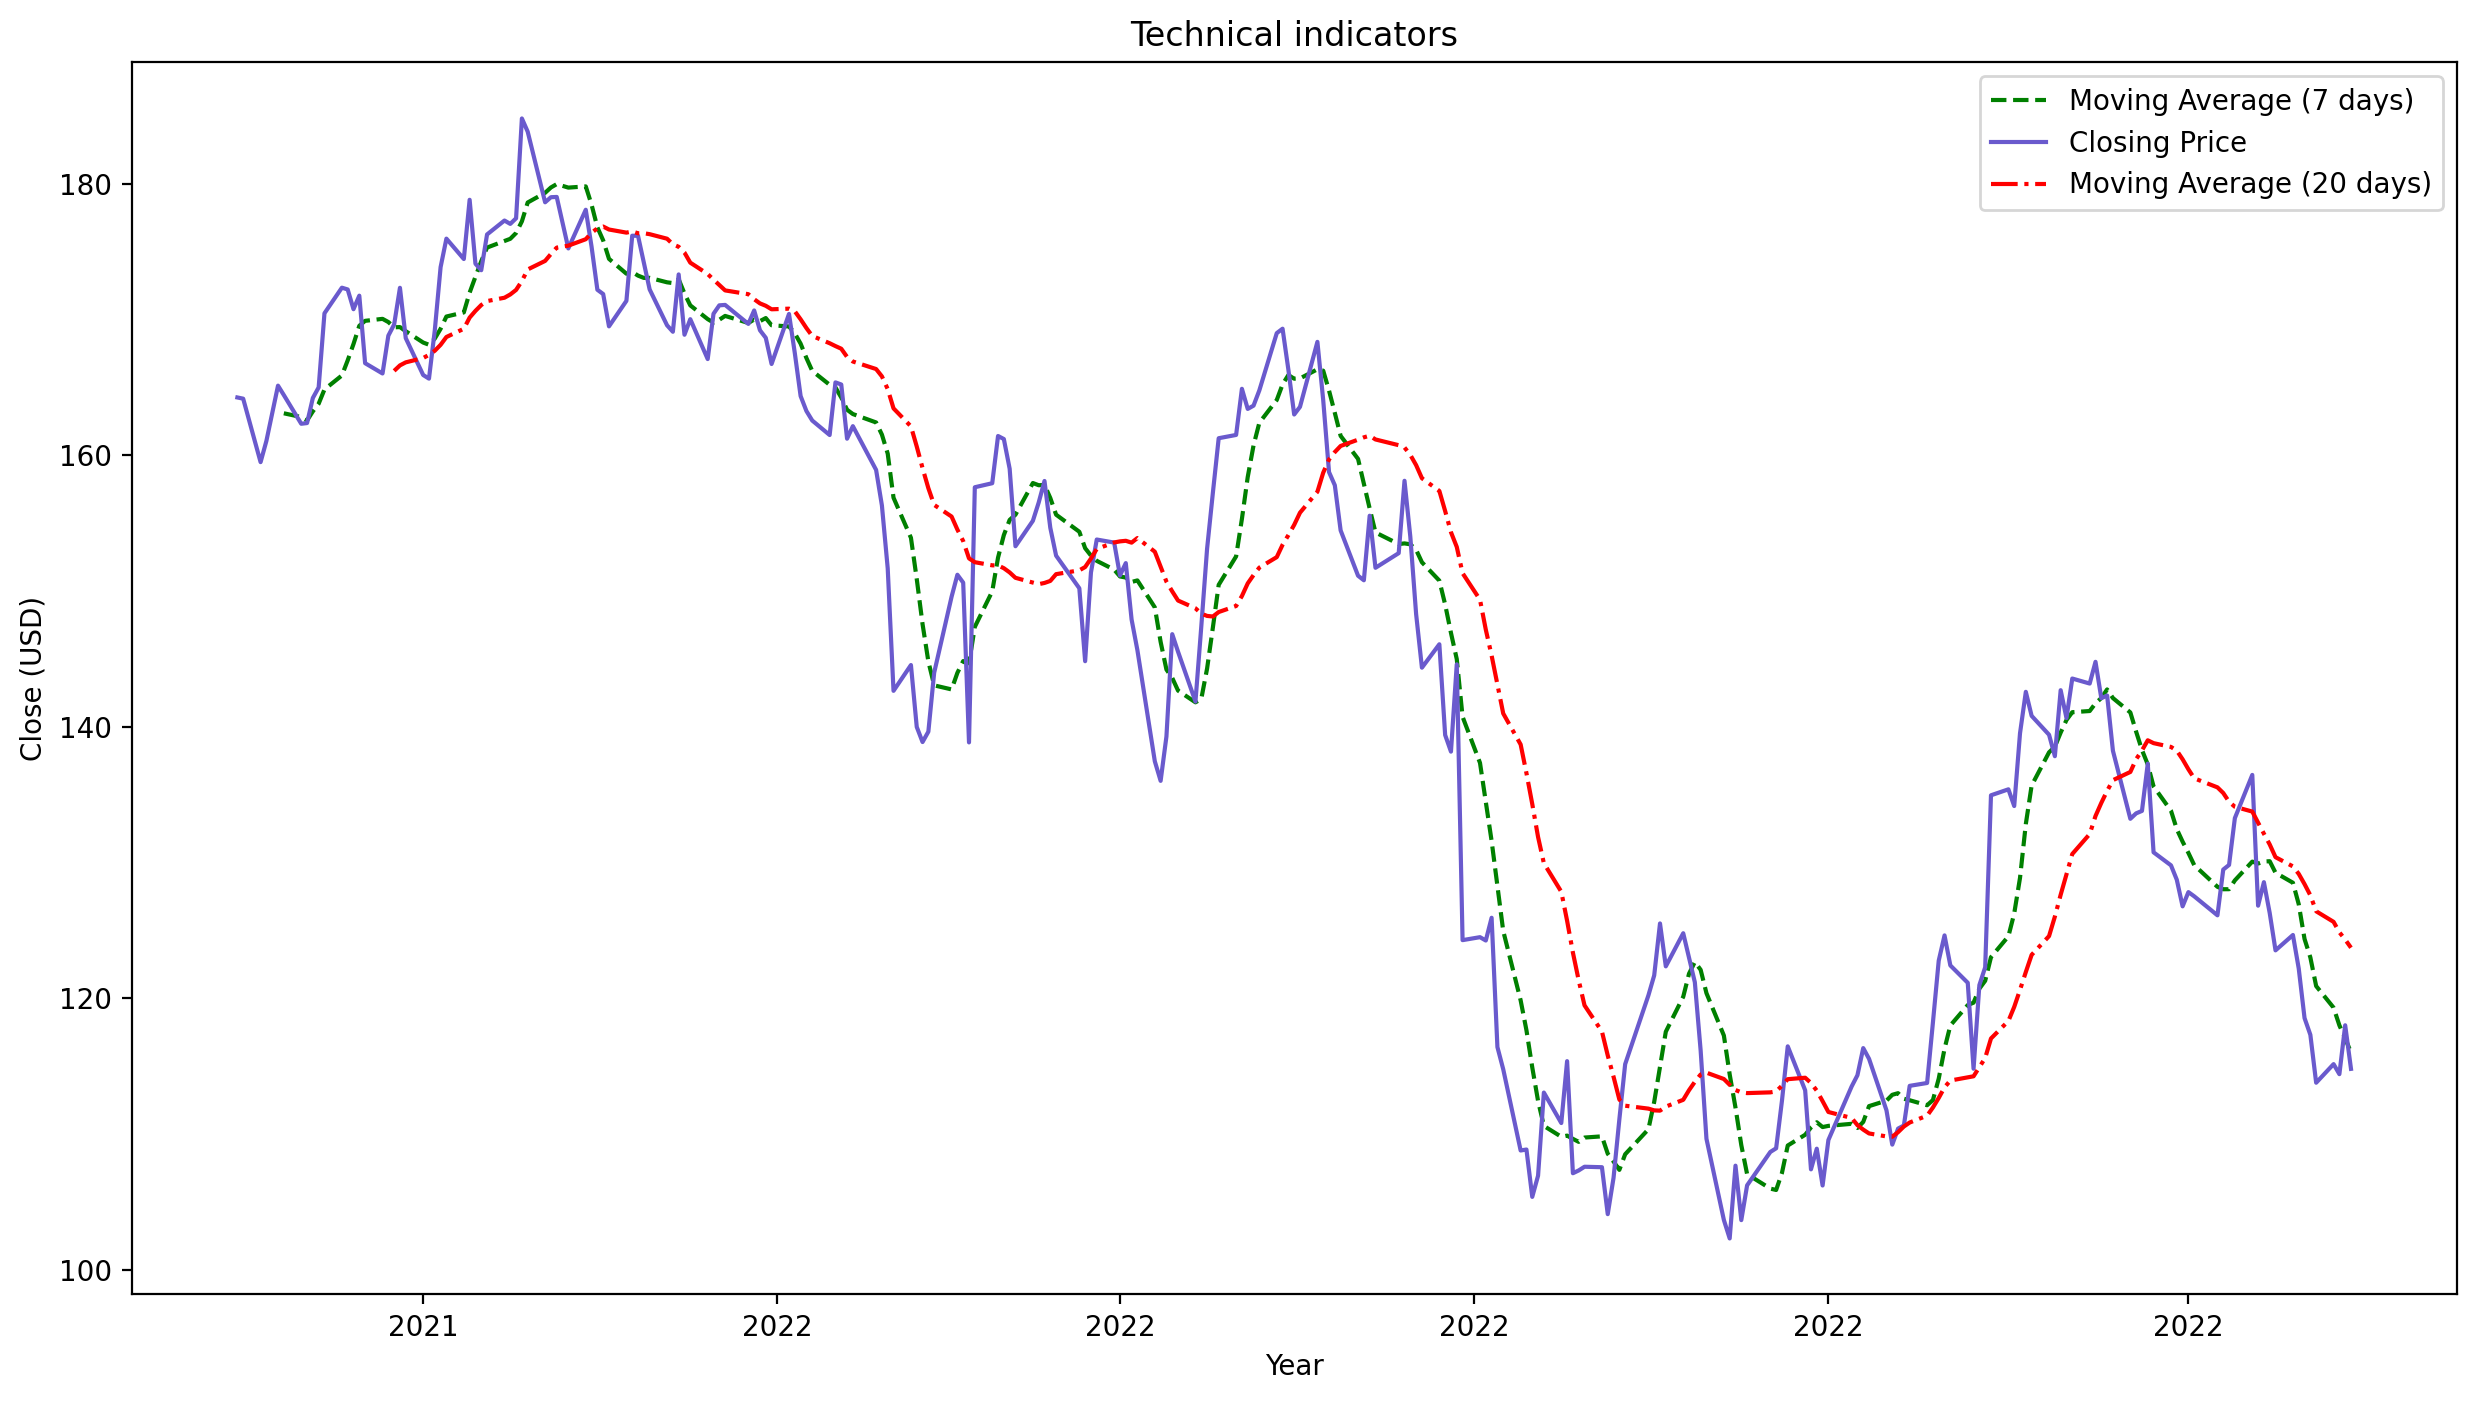

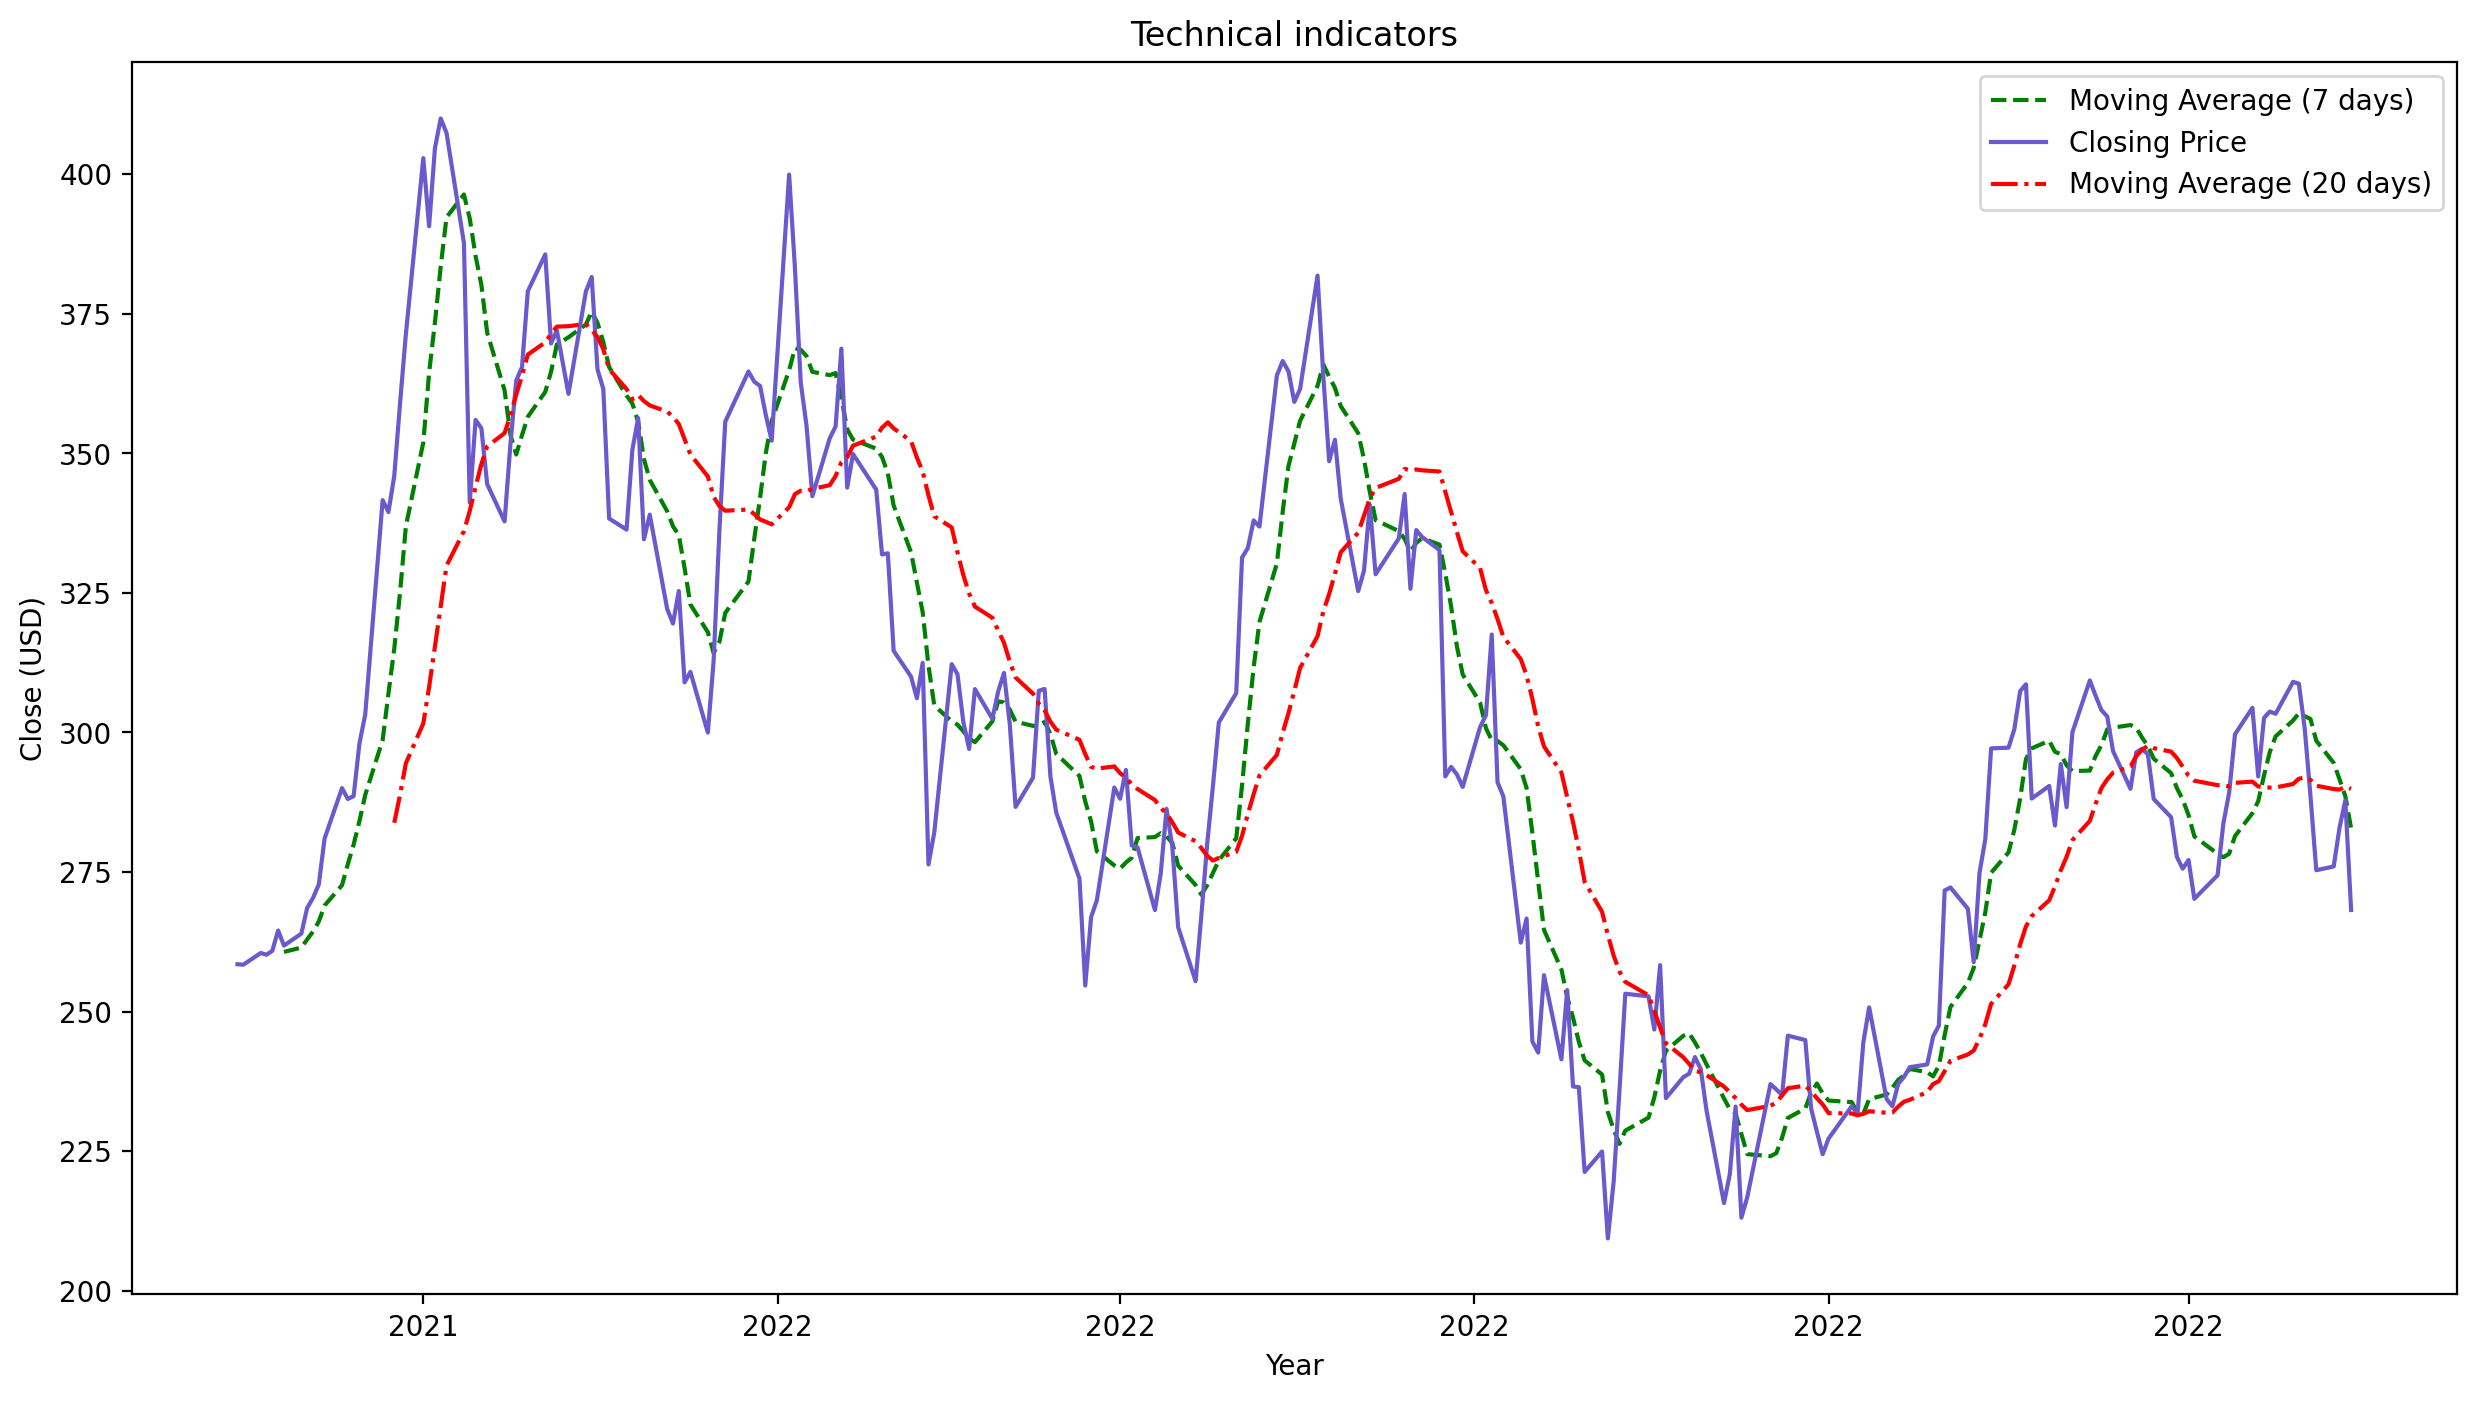

In [ ]:
tech_ind(tech_df)
tech_ind(tech_df_2)

In [ ]:
dataset.iloc[:, 1:] = pd.concat([dataset.iloc[:, 1:].ffill()])
dataset_2.iloc[:, 1:] = pd.concat([dataset_2.iloc[:, 1:].ffill()])

In [ ]:
def normalize_data(df, range, target_column):

    '''
    df: dataframe object
    range: type tuple -> (lower_bound, upper_bound)
        lower_bound: int
        upper_bound: int
    target_column: type str -> should reflect closing price of stock
    '''

    target_df_series = pd.DataFrame(df[target_column])
    data = pd.DataFrame(df.iloc[:, :])

    X_scaler = MinMaxScaler(feature_range=range)
    y_scaler = MinMaxScaler(feature_range=range)
    X_scaler.fit(data)
    y_scaler.fit(target_df_series)

    X_scale_dataset = X_scaler.fit_transform(data)
    y_scale_dataset = y_scaler.fit_transform(target_df_series)
    
    dump(X_scaler, open('X_scaler.pkl', 'wb'))
    dump(y_scaler, open('y_scaler.pkl', 'wb'))

    return (X_scale_dataset,y_scale_dataset)

In [ ]:
def batch_data(x_data,y_data, batch_size, predict_period):
    X_batched, y_batched, yc = list(), list(), list()

    for i in range(0,len(x_data),1):
        x_value = x_data[i: i + batch_size][:, :]
        y_value = y_data[i + batch_size: i + batch_size + predict_period][:, 0]
        yc_value = y_data[i: i + batch_size][:, :]
        if len(x_value) == batch_size and len(y_value) == predict_period:
            X_batched.append(x_value)
            y_batched.append(y_value)
            yc.append(yc_value)

    return np.array(X_batched), np.array(y_batched), np.array(yc)

In [ ]:
def split_train_test(data):
    train_size = len(data) - 20
    data_train = data[0:train_size]
    data_test = data[train_size:]
    return data_train, data_test

In [ ]:
def predict_index(dataset, X_train, batch_size, prediction_period):
    
    train_predict_index = dataset.iloc[batch_size: X_train.shape[0] + batch_size + prediction_period, :].index
    test_predict_index = dataset.iloc[X_train.shape[0] + batch_size:, :].index

    return train_predict_index, test_predict_index

In [ ]:
from sklearn.model_selection import train_test_split
dataset = dataset.select_dtypes(include=[np.number])
dataset_2 = dataset_2.select_dtypes(include=[np.number])
print(dataset)
X_scale_dataset, y_scale_dataset = normalize_data(dataset, (-1, 1), "Close")
X_batched, y_batched, yc = batch_data(X_scale_dataset, y_scale_dataset, batch_size=5, predict_period=1)
X_scale_dataset_2, y_scale_dataset_2 = normalize_data(dataset_2, (-1, 1), "Close")
X_batched_2, y_batched_2, yc_2 = batch_data(X_scale_dataset_2, y_scale_dataset_2, batch_size=5, predict_period=1)
print("X shape:", X_batched.shape)
print("y shape:", y_batched.shape)
print("yc shape:", yc.shape)

X_train, X_test, = split_train_test(X_batched)
y_train, y_test, = split_train_test(y_batched)
X_train_2, X_test_2, = split_train_test(X_batched_2)
y_train_2, y_test_2, = split_train_test(y_batched_2)
print("X_train", X_train)
print("X_test", X_test)
print("y_train", y_train)
print("y_test", y_test)

X_train_RF, X_test_RF, y_train_RF, y_test_RF = train_test_split(X_batched, y_batched, test_size=0.2, random_state=42)
yc_train, yc_test = split_train_test(yc)
index_train, index_test = predict_index(dataset, X_train, 5, 1)

X_train_RF_2, X_test_RF_2, y_train_RF_2, y_test_RF_2 = train_test_split(X_batched_2, y_batched_2, test_size=0.2, random_state=42)
yc_train_2, yc_test_2 = split_train_test(yc_2)
index_train_2, index_test_2 = predict_index(dataset_2, X_train_2, 5, 1)

           Open        High         Low       Close   Adj Close     Volume  \
0    170.104996  173.949997  169.300003  172.328506  172.328506  114174000   
1    165.001007  168.740997  163.666000  168.621506  168.621506  129722000   
2    168.089996  168.792999  164.600998  165.905502  165.905502   72178000   
3    165.750504  166.556000  164.177505  165.637497  165.637497   52552000   
4    165.449997  169.746002  164.876007  169.199997  169.199997   67944000   
..          ...         ...         ...         ...         ...        ...   
227  116.000000  116.050003  112.059998  113.779999  113.779999   65126700   
228  113.300003  117.339996  113.129997  115.150002  115.150002   62723300   
229  117.199997  118.320000  113.050003  114.410004  114.410004   60094700   
230  114.379997  118.699997  113.800003  118.010002  118.010002   55763800   
231  115.599998  116.070000  113.059998  114.800003  114.800003   58969700   

     sentiment_score  sentiment_label         MA7        MA20  

In [ ]:
input_dim = X_train.shape[1] 
feature_size = X_train.shape[2] 
output_dim = y_train.shape[1]

input_dim_2 = X_train_2.shape[1] 
feature_size_2 = X_train_2.shape[2] 
output_dim_2 = y_train_2.shape[1]

In [ ]:
def make_generator_model(input_dim, output_dim, feature_size):
    model = tf.keras.Sequential([LSTM(units = 1024, return_sequences = True, 
                                    input_shape=(input_dim, feature_size),recurrent_dropout = 0.3),
                               LSTM(units = 512, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 256, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 128, return_sequences = True, recurrent_dropout = 0.3),
                               LSTM(units = 64, recurrent_dropout = 0.3),
                               Dense(32),
                               Dense(16),
                               Dense(8),
                               Dense(units=output_dim)])
    return model

In [ ]:
def make_discriminator_model(input_dim):
    cnn_net = tf.keras.Sequential()
    cnn_net.add(Conv1D(8, input_shape=(input_dim+1, 1), kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(16, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(32, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(64, kernel_size=3, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(Conv1D(128, kernel_size=1, strides=2, padding='same', activation=LeakyReLU(alpha=0.01)))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False))
    cnn_net.add(LeakyReLU())
    cnn_net.add(Dense(220, use_bias=False, activation='relu'))
    cnn_net.add(Dense(1, activation='sigmoid'))
    return cnn_net

In [ ]:
def discriminator_loss(real_output, fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    real_loss = loss_f(tf.ones_like(real_output), real_output)
    fake_loss = loss_f(tf.zeros_like(fake_output), fake_output)
    total_loss = real_loss + fake_loss
    return total_loss

def generator_loss(fake_output):
    loss_f = tf.keras.losses.BinaryCrossentropy(from_logits=True)
    loss = loss_f(tf.ones_like(fake_output), fake_output)
    return loss

In [ ]:
@tf.function

def train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
@tf.function

def train_step_2(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer):
    with tf.GradientTape() as gen_tape, tf.GradientTape() as disc_tape:
        generated_data = generator(real_x, training=True)
        generated_data_reshape = tf.reshape(generated_data, [generated_data.shape[0], generated_data.shape[1], 1])
        d_fake_input = tf.concat([tf.cast(generated_data_reshape, tf.float64), yc], axis=1)
        real_y_reshape = tf.reshape(real_y, [real_y.shape[0], real_y.shape[1], 1])
        d_real_input = tf.concat([real_y_reshape, yc], axis=1)

        real_output = discriminator(d_real_input, training=True)
        fake_output = discriminator(d_fake_input, training=True)

        g_loss = generator_loss(fake_output)
        disc_loss = discriminator_loss(real_output, fake_output)

    gradients_of_generator = gen_tape.gradient(g_loss, generator.trainable_variables)
    gradients_of_discriminator = disc_tape.gradient(disc_loss, discriminator.trainable_variables)

    g_optimizer.apply_gradients(zip(gradients_of_generator, generator.trainable_variables))
    d_optimizer.apply_gradients(zip(gradients_of_discriminator, discriminator.trainable_variables))

    return real_y, generated_data, {'d_loss': disc_loss, 'g_loss': g_loss}

In [ ]:
def train(real_x, real_y, yc, stock, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock}/disc riminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])

    plt.plot(train_info["discriminator_loss"], label = "discriminator_loss")
    plt.plot(train_info["generator_loss"], label = "generator_loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.show()
    
    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)

In [ ]:
def train_2(real_x, real_y, yc, stock, Epochs, generator, discriminator, g_optimizer, d_optimizer, checkpoint = 50):
    train_info = {}
    train_info["discriminator_loss"] = []
    train_info["generator_loss"] = []

    for epoch in tqdm(range(Epochs)):
        real_price, fake_price, loss = train_step_2(real_x, real_y, yc, generator, discriminator, g_optimizer, d_optimizer)
        G_losses = []
        D_losses = []
        Real_price = []
        Predicted_price = []
        D_losses.append(loss['d_loss'].numpy())
        G_losses.append(loss['g_loss'].numpy())
        Predicted_price.append(fake_price.numpy())
        Real_price.append(real_price.numpy())

        if (epoch + 1) % checkpoint == 0:
            tf.keras.models.save_model(generator, f'./models_gan/{stock}/generator_V_%d.h5' % epoch)
            tf.keras.models.save_model(discriminator, f'./models_gan/{stock}/discriminator_V_%d.h5' % epoch)
            print('epoch', epoch + 1, 'discriminator_loss', loss['d_loss'].numpy(), 'generator_loss', loss['g_loss'].numpy())
    
        train_info["discriminator_loss"].append(D_losses)
        train_info["generator_loss"].append(G_losses)
  
    Predicted_price = np.array(Predicted_price)
    Predicted_price = Predicted_price.reshape(Predicted_price.shape[1], Predicted_price.shape[2])
    Real_price = np.array(Real_price)
    Real_price = Real_price.reshape(Real_price.shape[1], Real_price.shape[2])
    
    plt.plot(train_info["discriminator_loss"], label='Disc_loss', color='#000000')
    plt.plot(train_info["generator_loss"], label='Gen_loss', color='#FF0000')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.show()
    
    return Predicted_price, Real_price, np.sqrt(mean_squared_error(Real_price, Predicted_price)) / np.mean(Real_price)


In [ ]:
from pickle import load
def plot_results(Real_price, Predicted_price, index_train):
    X_scaler = load(open('/content/X_scaler.pkl', 'rb'))
    y_scaler = load(open('/content/y_scaler.pkl', 'rb'))
    train_predict_index = index_train

    rescaled_Real_price = y_scaler.inverse_transform(Real_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=train_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=train_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)

    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"])
    plt.plot(predict_result["predicted_mean"], color = 'r')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title("The result of Training", fontsize=20)
    plt.show()

    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('-- Train RMSE -- ', RMSE)

In [ ]:
def plot_test_data(Real_test_price, Predicted_test_price, index_test ,stock):
    X_scaler = load(open('X_scaler.pkl', 'rb'))
    y_scaler = load(open('y_scaler.pkl', 'rb'))
    test_predict_index = index_test

    rescaled_Real_price = y_scaler.inverse_transform(Real_test_price)
    rescaled_Predicted_price = y_scaler.inverse_transform(Predicted_test_price)

    predict_result = pd.DataFrame()
    for i in range(rescaled_Predicted_price.shape[0]):
        y_predict = pd.DataFrame(rescaled_Predicted_price[i], columns=["predicted_price"], index=test_predict_index[i:i+output_dim])
        predict_result = pd.concat([predict_result, y_predict], axis=1, sort=False)
  
    real_price = pd.DataFrame()
    for i in range(rescaled_Real_price.shape[0]):
        y_train = pd.DataFrame(rescaled_Real_price[i], columns=["real_price"], index=test_predict_index[i:i+output_dim])
        real_price = pd.concat([real_price, y_train], axis=1, sort=False)
  
    predict_result['predicted_mean'] = predict_result.mean(axis=1)
    real_price['real_mean'] = real_price.mean(axis=1)
    predicted = predict_result["predicted_mean"]
    real = real_price["real_mean"]
    For_MSE = pd.concat([predicted, real], axis = 1)
    RMSE = np.sqrt(mean_squared_error(predicted, real))
    print('Test RMSE: ', RMSE)
    
    plt.figure(figsize=(16, 8))
    plt.plot(real_price["real_mean"], color='#00008B')
    plt.plot(predict_result["predicted_mean"], color = '#8B0000', linestyle='--')
    plt.xlabel("Date")
    plt.ylabel("Stock price")
    plt.legend(("Real price", "Predicted price"), loc="upper left", fontsize=16)
    plt.title(f"Prediction on test data for {stock}", fontsize=20)
    plt.show()

In [ ]:
lr = 5e-4
epochs = 500

g_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
d_optimizer = tf.keras.optimizers.Adam(learning_rate=lr)

g_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=lr)
d_optimizer_2 = tf.keras.optimizers.Adam(learning_rate=lr)

generator = make_generator_model(X_train.shape[1], output_dim, X_train.shape[2])
generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
generator.fit(X_train, y_train, epochs=10)
generator.save('saved_model.h5')
discriminator = make_discriminator_model(X_train.shape[1])

generator_2 = make_generator_model(X_train_2.shape[1], output_dim_2, X_train_2.shape[2])
generator_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
generator_2.fit(X_train_2, y_train_2, epochs=10)
generator_2.save('saved_model_2.h5')
discriminator_2 = make_discriminator_model(X_train_2.shape[1])

Epoch 1/10
7/7 [==============================] - 13s 310ms/step - loss: -2.6925 - accuracy: 0.0000e+00
Epoch 2/10
7/7 [==============================] - 2s 308ms/step - loss: -3.0902 - accuracy: 0.0000e+00
Epoch 3/10
7/7 [==============================] - 2s 306ms/step - loss: -3.0545 - accuracy: 0.0048
Epoch 4/10
7/7 [==============================] - 2s 310ms/step - loss: -3.0017 - accuracy: 0.0048
Epoch 5/10
7/7 [==============================] - 2s 313ms/step - loss: -3.1603 - accuracy: 0.0048
Epoch 6/10
7/7 [==============================] - 2s 313ms/step - loss: -3.2184 - accuracy: 0.0048
Epoch 7/10
7/7 [==============================] - 2s 307ms/step - loss: -3.2327 - accuracy: 0.0048
Epoch 8/10
7/7 [==============================] - 2s 316ms/step - loss: -3.2468 - accuracy: 0.0048
Epoch 9/10
7/7 [==============================] - 2s 307ms/step - loss: -3.2523 - accuracy: 0.0048
Epoch 10/10
7/7 [==============================] - 2s 311ms/step - loss: -3.2688 - accuracy: 0.0048


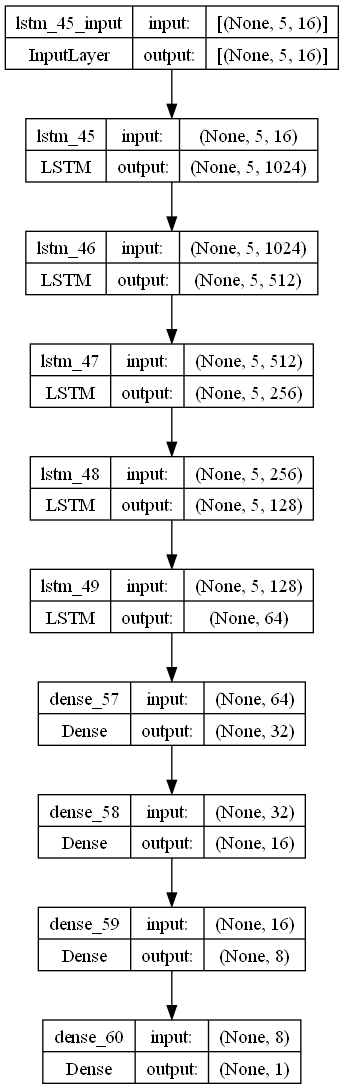

In [ ]:
plot_model(generator, to_file='generator_keras_model.png', show_shapes=True)

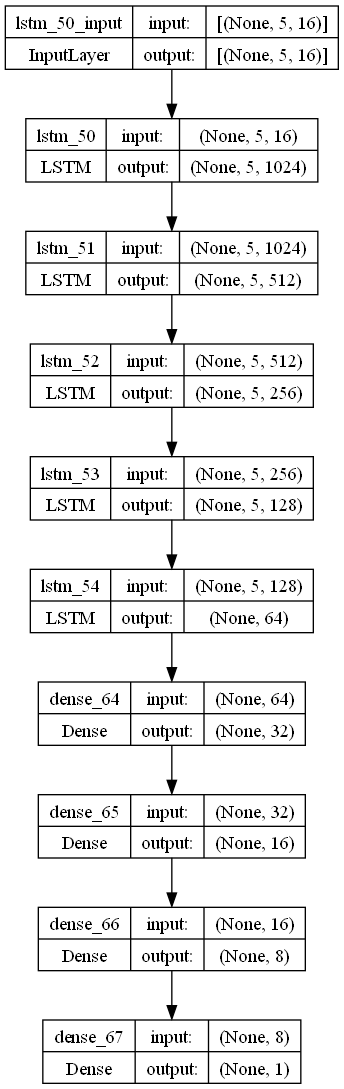

In [ ]:
plot_model(generator_2, to_file='generator_keras_model_2.png', show_shapes=True)

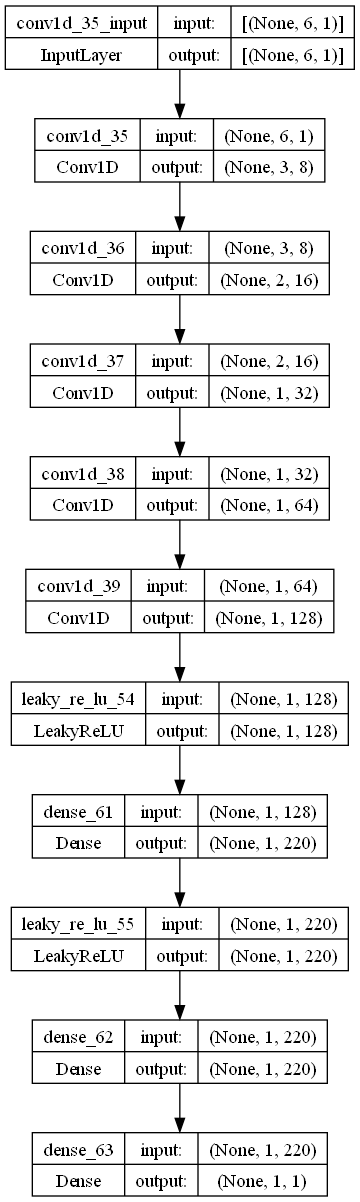

In [ ]:
tf.keras.utils.plot_model(discriminator, to_file='discriminator_keras_model.png', show_shapes=True)

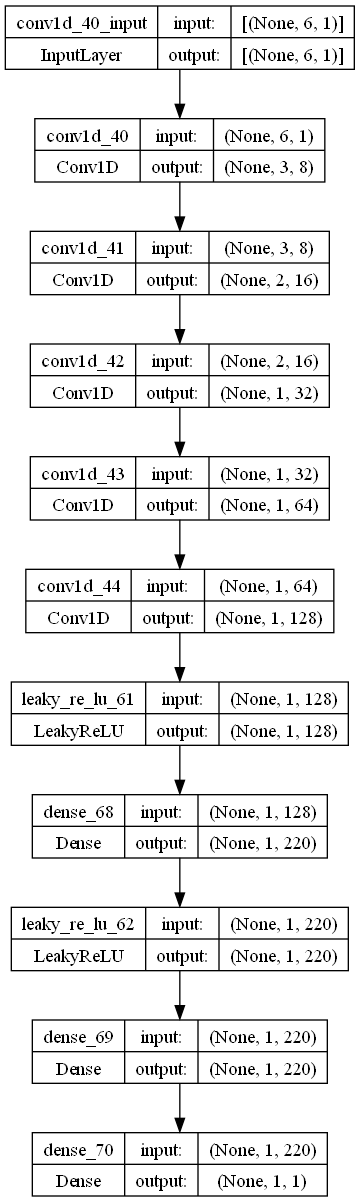

In [ ]:
tf.keras.utils.plot_model(discriminator_2, to_file='discriminator_keras_model_2.png', show_shapes=True)

 10%|▉         | 49/500 [00:47<04:20,  1.73it/s] 

 10%|█         | 50/500 [00:47<04:45,  1.58it/s]

epoch 50 discriminator_loss 1.3832997 generator_loss 0.67885476


 20%|█▉        | 99/500 [01:17<03:59,  1.68it/s]

 20%|██        | 100/500 [01:17<04:20,  1.54it/s]

epoch 100 discriminator_loss 1.3873775 generator_loss 0.680281


 30%|██▉       | 149/500 [01:47<03:30,  1.67it/s]

 30%|███       | 150/500 [01:48<03:46,  1.55it/s]

epoch 150 discriminator_loss 1.3865898 generator_loss 0.6985425


 40%|███▉      | 199/500 [02:18<03:22,  1.48it/s]

 40%|████      | 200/500 [02:19<03:35,  1.39it/s]

epoch 200 discriminator_loss 1.3877547 generator_loss 0.6856126


 50%|████▉     | 249/500 [02:48<02:34,  1.62it/s]

 50%|█████     | 250/500 [02:49<02:49,  1.47it/s]

epoch 250 discriminator_loss 1.3860862 generator_loss 0.69472104


 60%|█████▉    | 299/500 [03:20<02:01,  1.66it/s]

 60%|██████    | 300/500 [03:20<02:09,  1.54it/s]

epoch 300 discriminator_loss 1.3859824 generator_loss 0.695855


 70%|██████▉   | 349/500 [03:51<01:33,  1.62it/s]

 70%|███████   | 350/500 [03:51<01:39,  1.51it/s]

epoch 350 discriminator_loss 1.385973 generator_loss 0.69494313


 80%|███████▉  | 399/500 [04:21<01:00,  1.66it/s]

 80%|████████  | 400/500 [04:22<01:06,  1.50it/s]

epoch 400 discriminator_loss 1.3858414 generator_loss 0.6945535


 90%|████████▉ | 449/500 [04:51<00:30,  1.68it/s]

 90%|█████████ | 450/500 [04:52<00:31,  1.56it/s]

epoch 450 discriminator_loss 1.3864193 generator_loss 0.69186276


100%|█████████▉| 499/500 [05:22<00:00,  1.64it/s]

100%|██████████| 500/500 [05:23<00:00,  1.55it/s]

epoch 500 discriminator_loss 1.3866279 generator_loss 0.6927823


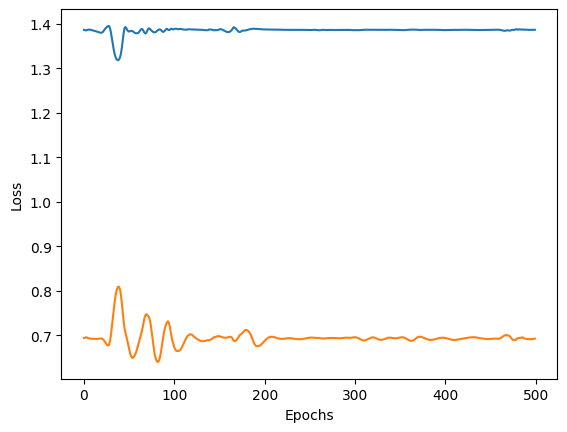

In [ ]:
predicted_price, real_price, RMSPE = train(X_train, y_train, yc_train, stock_name, epochs, generator, discriminator, g_optimizer, d_optimizer)

In [ ]:
predicted_price_2, real_price_2, RMSPE_2 = train_2(X_train_2, y_train_2, yc_train_2, stock_name_test, epochs, generator_2, discriminator_2, g_optimizer_2, d_optimizer_2)

  0%|          | 0/500 [00:01<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
test_generator = tf.keras.models.load_model(f'./models_gan/{stock_name}/generator_V_{epochs-1}.h5')
test_generator.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
test_generator_2 = tf.keras.models.load_model(f'./models_gan/{stock_name_test}/generator_V_{epochs-1}.h5')
test_generator_2.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
@tf.function 

def eval_op(generator, real_x):
    generated_data = generator(real_x, training = False)

    return generated_data

In [ ]:
predicted_test_data = eval_op(test_generator, X_test)
plot_test_data(y_test, predicted_test_data,index_test , stock_name)

ValueError: in user code:

    File "C:\Users\zenil\AppData\Local\Temp\ipykernel_17512\2616632993.py", line 4, in eval_op  *
        generated_data = generator(real_x, training = False)
    File "C:\Users\zenil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\zenil\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\engine\input_spec.py", line 298, in assert_input_compatibility
        raise ValueError(

    ValueError: Input 0 of layer "sequential_12" is incompatible with the layer: expected shape=(None, 5, 16), found shape=(51, 3)


Test RMSE:  20.525405437506507
Test R2:  nan


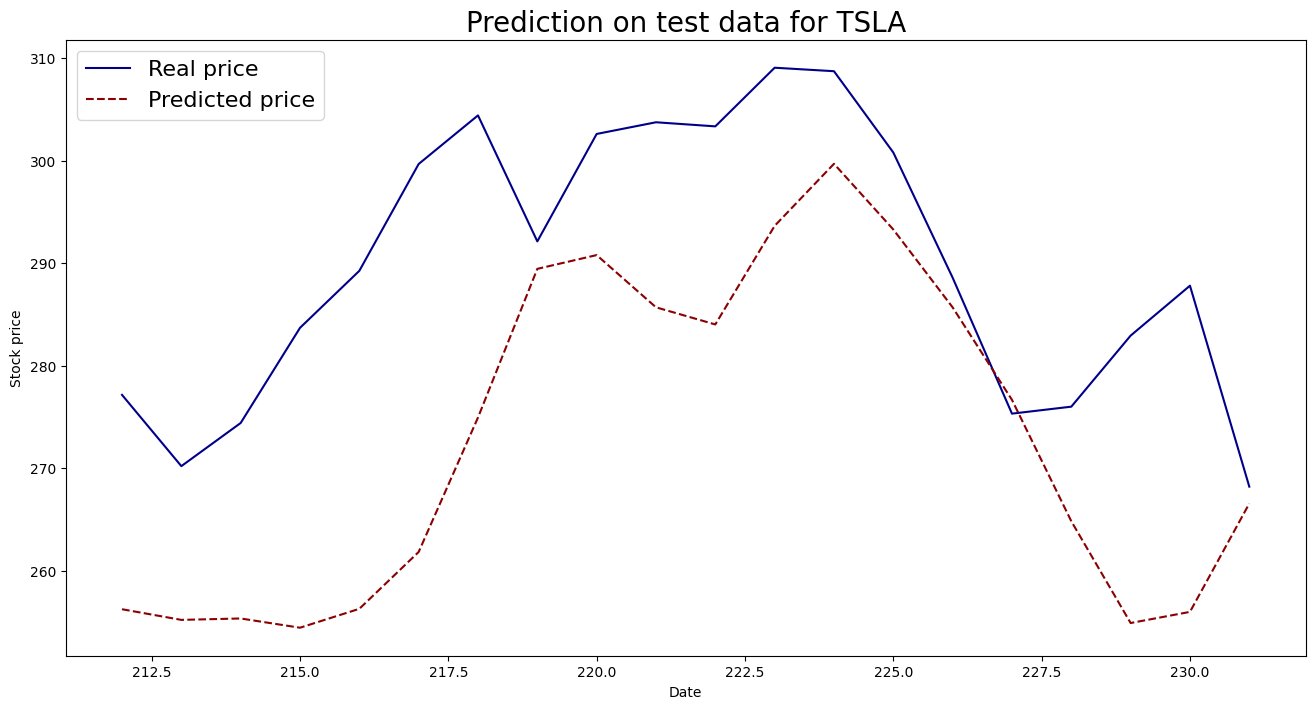

20.525405437506507

In [ ]:
predicted_test_data_2 = eval_op(test_generator_2, X_test_2)
plot_test_data(y_test_2, predicted_test_data_2,index_test_2 , stock_name_test)

In [ ]:
from sklearn.ensemble import RandomForestRegressor
def random_forest_regression(X_train, y_train, X_test, y_test, random_state=42):
    X_train = X_train.reshape((X_train.shape[0], -1))
    X_test = X_test.reshape((X_test.shape[0], -1))
    rf_model = RandomForestRegressor(n_estimators=100, random_state=random_state)

    rf_model.fit(X_train, y_train)

    y_pred = rf_model.predict(X_test)

    mse = mean_squared_error(y_test, y_pred)

    r2 = r2_score(y_test, y_pred)

    plt.scatter(y_test, y_pred, color='blue')
    plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], linestyle='--', color='green')
    plt.xlabel('Actual Values')
    plt.ylabel('Predicted Values')
    plt.title('Random Forest Regression: Actual vs. Predicted')
    plt.show()

    return {"Mean Squared Error": mse, "R-squared": r2}

In [ ]:
import pandas as pd
train_dates = pd.to_datetime(final_df['Date'])
print(final_df_2.columns)
train_dates_2 = pd.to_datetime(final_df_2['Date'])

cols = [
    'Open',
    'High', 'Low',
    'Close',
    'Volume',
    'Adj Close',
    'sentiment_score',
    'sentiment_label'
        ]

print(final_df.columns)

df_for_training = final_df[cols].astype(float)
df_for_training_2 = final_df_2[cols].astype(float)
df_for_training.index=final_df['Date']
df_for_training_2.index=final_df_2['Date']
df_for_training_2

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'sentiment_score', 'sentiment_label', 'dataset', 'MA7', 'MA20', 'MACD',
       '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum'],
      dtype='object')
Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume',
       'sentiment_score', 'sentiment_label', 'dataset', 'MA7', 'MA20', 'MACD',
       '20SD', 'upper_band', 'lower_band', 'EMA', 'logmomentum'],
      dtype='object')


,Open,High,Low,Close,Volume,Adj Close,sentiment_score,sentiment_label
Date,,,,,,,,
2021-09-30,260.333344,263.043335,258.333344,258.493347,53868000.0,258.493347,0.231552,1.0
2021-10-01,259.466675,260.260010,254.529999,258.406677,51094200.0,258.406677,0.233704,1.0
2021-10-04,265.500000,268.989990,258.706665,260.510010,91449900.0,260.510010,0.135388,1.0
2021-10-05,261.600006,265.769989,258.066681,260.196655,55297800.0,260.196655,0.069445,1.0
2021-10-06,258.733337,262.220001,257.739990,260.916656,43898400.0,260.916656,0.199940,1.0
...,...,...,...,...,...,...,...,...
2022-09-23,283.089996,284.500000,272.820007,275.329987,63748400.0,275.329987,0.143601,1.0
2022-09-26,271.829987,284.089996,270.309998,276.010010,58076900.0,276.010010,0.145532,1.0
2022-09-27,283.839996,288.670013,277.510010,282.940002,61925200.0,282.940002,0.188188,1.0


RMSE: 1.668265679125674


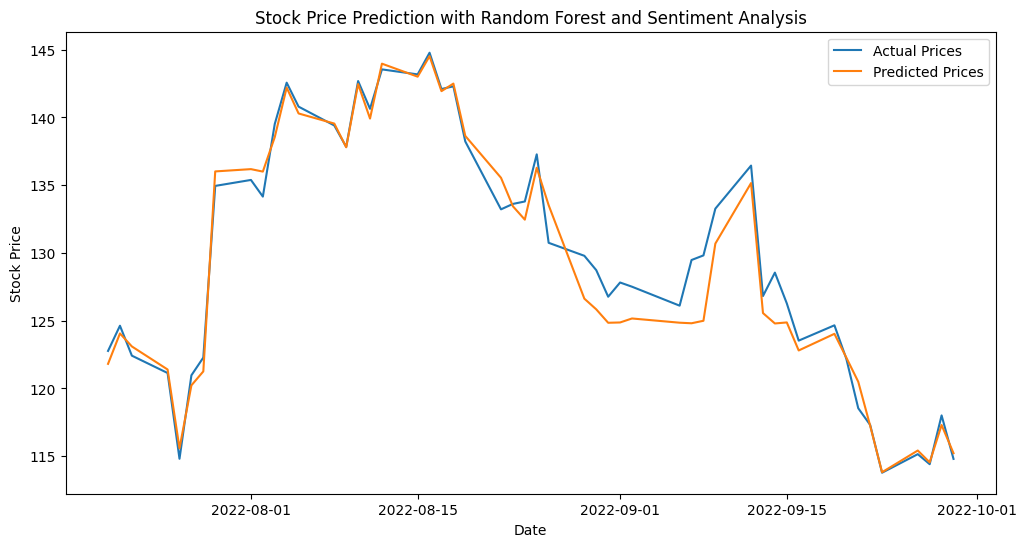

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

merged_data = df_for_training

train_size = int(len(merged_data) * 0.8)
train_data, test_data = merged_data[:train_size], merged_data[train_size:]

X_train = train_data.drop(columns=['Close'])
y_train = train_data['Close']
X_test = test_data.drop(columns=['Close'])
y_test = test_data['Close']

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

predictions = rf_model.predict(X_test)

rmse = mean_squared_error(y_test, predictions, squared=False)

print(f"RMSE: {rmse}")

plt.figure(figsize=(12, 6))
plt.plot(test_data.index, y_test, label='Actual Prices')
plt.plot(test_data.index, predictions, label='Predicted Prices')
plt.title('Stock Price Prediction with Random Forest and Sentiment Analysis')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


-0.0772
0.25
-0.3182
0.2382
0.7783
0.4404
0.0
0.0
-0.885
0.75
0.0
0.9022
0.7184
0.1779
0.4767
0.1779
0.7845
-0.6604
0.4588
0.9092
0.0
0.0
-0.0754
-0.1027
-0.3054
-0.296
0.0
-0.5499
-0.296
0.5709
0.09
0.0
0.7184
-0.7096
0.6688
0.0
0.0
0.0
0.936
0.0
0.0
0.0
-0.2382
-0.1779
0.34
0.5859
0.9118
0.0
-0.34
0.8402
0.1779
-0.782
-0.1655
0.1779
-0.5423
0.0
0.8555
0.0
0.6704
-0.4588
0.4404
0.1779
0.0
0.0
-0.1546
0.0
0.8807
0.1779
0.0
0.0
0.2023
0.5173
0.0
0.7712
0.0
0.6523
-0.7096
0.296
0.7269
0.4404
0.0
0.347
0.347
0.1779
0.836
0.1779
0.8625
-0.3129
0.8519
-0.1531
0.1779
-0.128
-0.7418
0.8038
0.5106
0.0
0.891
0.0
-0.6808
0.0
0.9364
0.1779
0.1779
0.6983
0.8402
-0.7096
0.0
-0.6705
-0.2732
0.091
0.0516
0.0
0.128
0.1779
0.6597
0.3034
0.1779
0.5267
0.4404
0.1779
0.0
0.8844
-0.4019
0.0
0.0
0.4019
0.7712
0.8777
-0.2023
0.6353
-0.1779
0.9645
0.9642
0.0
0.0
-0.4019
0.886
0.0
0.0
0.3612
0.0516
0.3818
0.6597
0.1779
-0.2023
-0.1511
-0.4767
0.0
0.0
-0.5574
0.0
0.876
0.8953
0.2023
0.2617
0.5803
0.0
-0.532
-0.

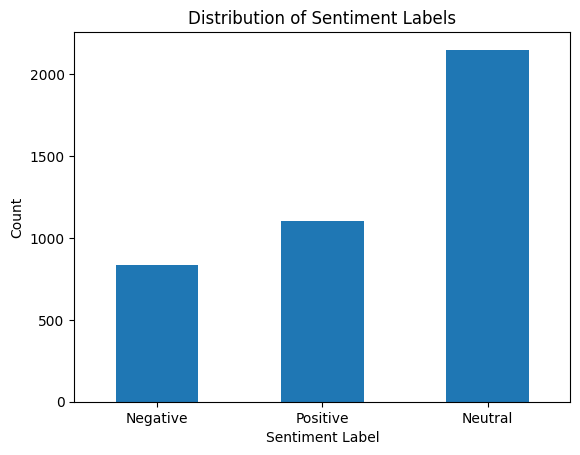

In [ ]:
sentiment_labels = []

for score in sent_df['sentiment_score']:
    print(score)
    if score >= 0.05:
        sentiment_labels.append("Positive")
    elif score <= -0.05:
        sentiment_labels.append("Negative")
    else:
        sentiment_labels.append("Neutral")

sent_df['sentiment_label'] = sentiment_labels

print(sent_df['sentiment_label'])

ax = sent_df.groupby('sentiment_label').size().plot(kind='bar', title='Distribution of Sentiment Labels', legend=False)
ax.set_xticklabels(['Negative', 'Positive', 'Neutral'], rotation=0)
ax.set_xlabel('Sentiment Label')
ax.set_ylabel('Count')

Tweet, sentiment_score = list(sent_df['Tweet']), list(sent_df['sentiment_score'])

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
RMSE (with sentiment_score only): 0.2917127861862913
RMSE (without sentiment_score): 0.4362766758858304


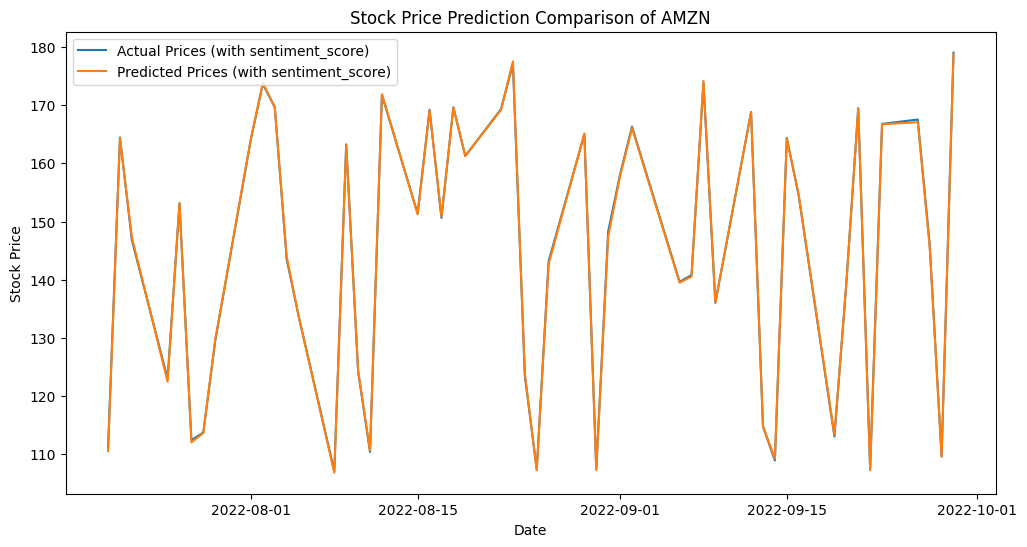

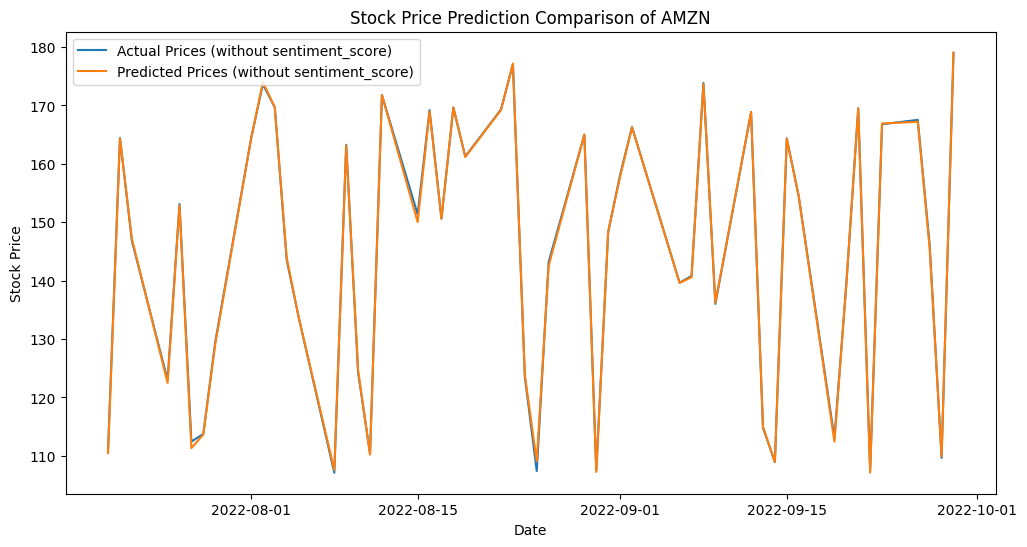

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt


merged_data = df_for_training
X_sentiment = merged_data[['sentiment_score', 'sentiment_label', 'Close']]
y_sentiment = merged_data['Close']

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X_sentiment, y_sentiment, test_size=0.2, random_state=42
)

rf_model_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sentiment.fit(X_train_sentiment, y_train_sentiment)

predictions_sentiment = rf_model_sentiment.predict(X_test_sentiment)
rmse_sentiment = mean_squared_error(y_test_sentiment, predictions_sentiment, squared=False)

X_without_sentiment = merged_data.drop(columns=['sentiment_score', 'sentiment_label'])
print(X_without_sentiment.columns)
y_without_sentiment = merged_data['Close']

X_train_without_sentiment, X_test_without_sentiment, y_train_without_sentiment, y_test_without_sentiment = train_test_split(
    X_without_sentiment, y_without_sentiment, test_size=0.2, random_state=42
)

rf_model_without_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_without_sentiment.fit(X_train_without_sentiment, y_train_without_sentiment)

predictions_without_sentiment = rf_model_without_sentiment.predict(X_test_without_sentiment)
rmse_without_sentiment = mean_squared_error(y_test_without_sentiment, predictions_without_sentiment, squared=False)

print(f"RMSE (with sentiment_score only): {rmse_sentiment}")
print(f"RMSE (without sentiment_score): {rmse_without_sentiment}")

plt.figure(figsize=(12, 6))
plt.title('Stock Price Prediction Comparison of AMZN')
plt.plot(merged_data.index[train_size:], y_test_sentiment, label='Actual Prices (with sentiment_score)')
plt.plot(merged_data.index[train_size:], predictions_sentiment, label='Predicted Prices (with sentiment_score)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[train_size:], y_test_without_sentiment, label='Actual Prices (without sentiment_score)')
plt.plot(merged_data.index[train_size:], predictions_without_sentiment, label='Predicted Prices (without sentiment_score)')
plt.title('Stock Price Prediction Comparison of AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Index(['Open', 'High', 'Low', 'Close', 'Volume', 'Adj Close'], dtype='object')
RMSE (with sentiment_score only): 1.285778881739186
RMSE (without sentiment_score): 1.387252072780375


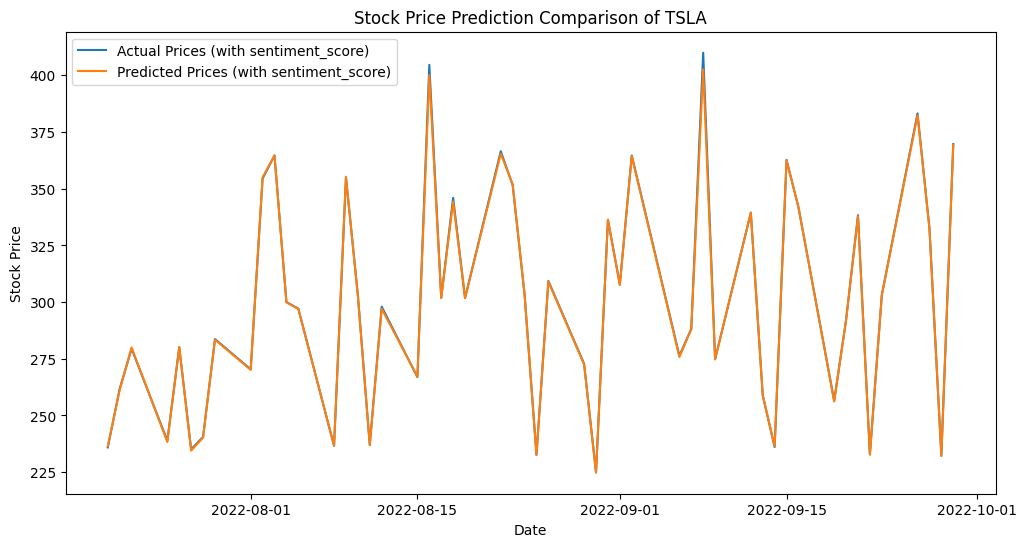

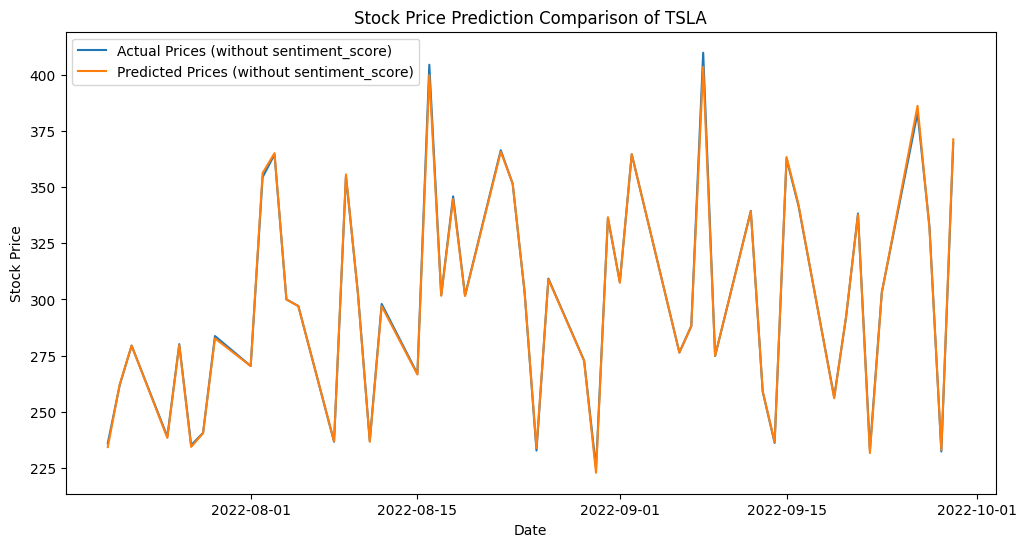

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

merged_data = df_for_training_2

X_sentiment = merged_data[['sentiment_score', 'sentiment_label', 'Close']]
y_sentiment = merged_data['Close']

X_train_sentiment, X_test_sentiment, y_train_sentiment, y_test_sentiment = train_test_split(
    X_sentiment, y_sentiment, test_size=0.2, random_state=42
)

rf_model_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_sentiment.fit(X_train_sentiment, y_train_sentiment)

predictions_sentiment = rf_model_sentiment.predict(X_test_sentiment)
rmse_sentiment = mean_squared_error(y_test_sentiment, predictions_sentiment, squared=False)

X_without_sentiment = merged_data.drop(columns=['sentiment_score', 'sentiment_label'])
print(X_without_sentiment.columns)
y_without_sentiment = merged_data['Close']

X_train_without_sentiment, X_test_without_sentiment, y_train_without_sentiment, y_test_without_sentiment = train_test_split(
    X_without_sentiment, y_without_sentiment, test_size=0.2, random_state=42
)

rf_model_without_sentiment = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model_without_sentiment.fit(X_train_without_sentiment, y_train_without_sentiment)

predictions_without_sentiment = rf_model_without_sentiment.predict(X_test_without_sentiment)
rmse_without_sentiment = mean_squared_error(y_test_without_sentiment, predictions_without_sentiment, squared=False)

print(f"RMSE (with sentiment_score only): {rmse_sentiment}")
print(f"RMSE (without sentiment_score): {rmse_without_sentiment}")

plt.figure(figsize=(12, 6))
plt.title('Stock Price Prediction Comparison of TSLA')
plt.plot(merged_data.index[train_size:], y_test_sentiment, label='Actual Prices (with sentiment_score)')
plt.plot(merged_data.index[train_size:], predictions_sentiment, label='Predicted Prices (with sentiment_score)')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[train_size:], y_test_without_sentiment, label='Actual Prices (without sentiment_score)')
plt.plot(merged_data.index[train_size:], predictions_without_sentiment, label='Predicted Prices (without sentiment_score)')
plt.title('Stock Price Prediction Comparison of TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


In [ ]:
merged_data = df_for_training

X = merged_data[['Open', 'Adj Close', 'sentiment_score']] 
y = merged_data['Close'] 

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_without_train, X_without_test = X_train.drop(columns=['sentiment_score']), X_test.drop(columns=['sentiment_score'])
X_train.shape,X_without_train.shape


((201, 3), (201, 2))

In [ ]:
def plot_predictions_with_dates (type,twitter,dates,y_actual_rf,y_pred_rf):
    predicted_features=['Open','Adj Close']
    for i,predicted_feature in enumerate(predicted_features):
        plt.figure(figsize=(15,6))
        if twitter :
            plt.title(f'rf {type} prediction of {predicted_feature} feature After adding twitter sentiment analysis')
        else:
            plt.title(f'rf {type} prediction of {predicted_feature} feature without twitter sentiment analysis')
        sns.lineplot(x=dates, y=y_actual_rf[:,i],label='Actual')
        sns.lineplot(x=dates, y=y_pred_rf[:, i], label='Predicted')
        plt.show()
        error=mean_squared_error(y_actual_rf[:,i], y_pred_rf[:, i])
        print(f'Mean square error for {predicted_feature} ={error}')
    print('Total mean square error', mean_squared_error(y_actual_lstm, y_pred_lstm))

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix

merged_data = df_for_training

X_with_sentiment = merged_data[['sentiment_label', 'Close', 'sentiment_score']]
y_with_sentiment = merged_data['Close'].diff().fillna(0) 

y_with_sentiment = y_with_sentiment.apply(lambda x: 1 if x > 0 else 0)

X_train_with_sentiment, X_test_with_sentiment, y_train_with_sentiment, y_test_with_sentiment = train_test_split(
    X_with_sentiment, y_with_sentiment, test_size=0.2, random_state=42
)

nb_model_with_sentiment = GaussianNB()
nb_model_with_sentiment.fit(X_train_with_sentiment, y_train_with_sentiment)

predictions_with_sentiment = nb_model_with_sentiment.predict(X_test_with_sentiment)
accuracy_with_sentiment = accuracy_score(y_test_with_sentiment, predictions_with_sentiment)

print(f"Accuracy (with sentiment score): {accuracy_with_sentiment}")

X_without_sentiment = merged_data.drop(columns=['sentiment_label', 'sentiment_score' , 'Close'])
y_without_sentiment = merged_data['Close'].diff().fillna(0) 

y_without_sentiment = y_without_sentiment.apply(lambda x: 1 if x > 0 else 0)

X_train_without_sentiment, X_test_without_sentiment, y_train_without_sentiment, y_test_without_sentiment = train_test_split(
    X_without_sentiment, y_without_sentiment, test_size=0.2, random_state=42
)

nb_model_without_sentiment = GaussianNB()
nb_model_without_sentiment.fit(X_train_without_sentiment, y_train_without_sentiment)

predictions_without_sentiment = nb_model_without_sentiment.predict(X_test_without_sentiment)
accuracy_without_sentiment = accuracy_score(y_test_without_sentiment, predictions_without_sentiment)

print(f"Accuracy (without sentiment score): {accuracy_without_sentiment}")



Accuracy (with sentiment score): 0.6470588235294118
Accuracy (without sentiment score): 0.49019607843137253


In [ ]:
merged_data = df_for_training

X = merged_data[['Open', 'Adj Close', 'sentiment_score']]  # Include sentiment_score
y = merged_data['Close']  # Target variable (stock price)

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.05, random_state=0
)

                                                   
print(f'Data Split done.')
def model_Evaluate(model):

    y_pred = model.predict(X_test)

    print(classification_report(y_test, y_pred))
    
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive','Neutral']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

Data Split done.


RMSE for AMZN with sentiment analysis: 0.5693257598342444
RMSE for TSLA with sentiment analysis: 1.2438564979733806


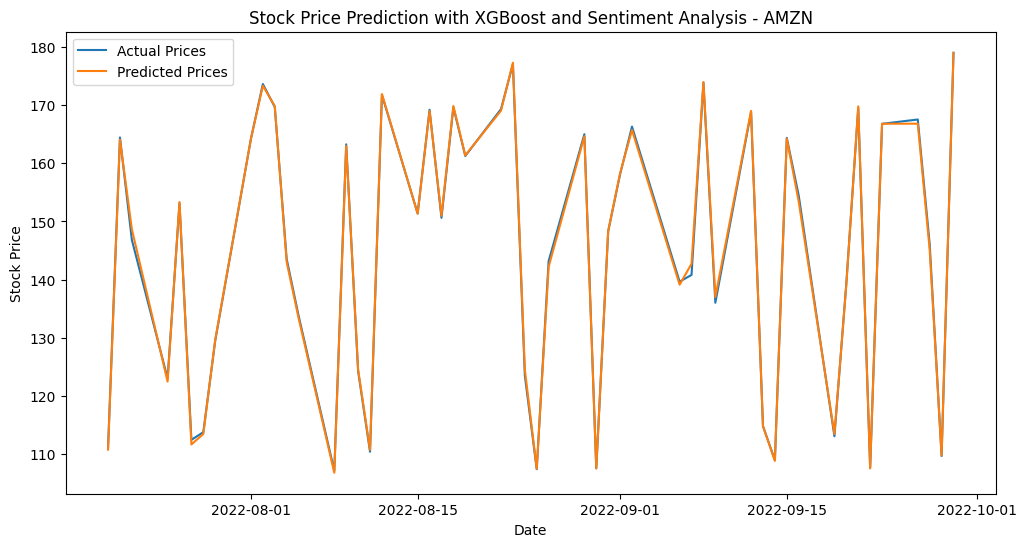

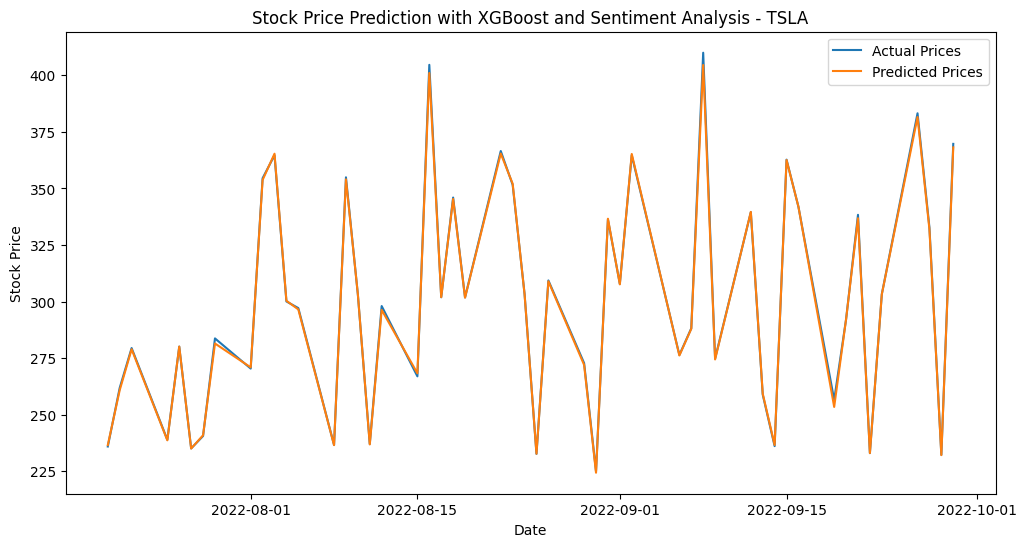

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

merged_data = df_for_training
merged_data_2 = df_for_training_2

X = merged_data[['sentiment_score' , 'Close',  'sentiment_label']]  # Features
y = merged_data['Close']  # Target variable (stock price)

X_2 = merged_data_2[['sentiment_score' , 'Close',  'sentiment_label']]  # Features
y_2 = merged_data_2['Close']  # Target variable (stock price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_2.fit(X_2_train, y_2_train)

predictions = xgb_model.predict(X_test)
predictions_2 = xgb_model_2.predict(X_2_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
rmse_2 = mean_squared_error(y_2_test, predictions_2, squared=False)
print(f"RMSE for AMZN with sentiment analysis: {rmse}")
print(f"RMSE for TSLA with sentiment analysis: {rmse_2}")

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(predictions):], y_test, label='Actual Prices')
plt.plot(merged_data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction with XGBoost and Sentiment Analysis - AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_2.index[-len(predictions_2):], y_2_test, label='Actual Prices')
plt.plot(merged_data_2.index[-len(predictions_2):], predictions_2, label='Predicted Prices')
plt.title('Stock Price Prediction with XGBoost and Sentiment Analysis - TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

RMSE for AMZN without sentiment analysis: 0.9466300407084843
RMSE for TSLA without sentiment analysis: 1.2429387108224161


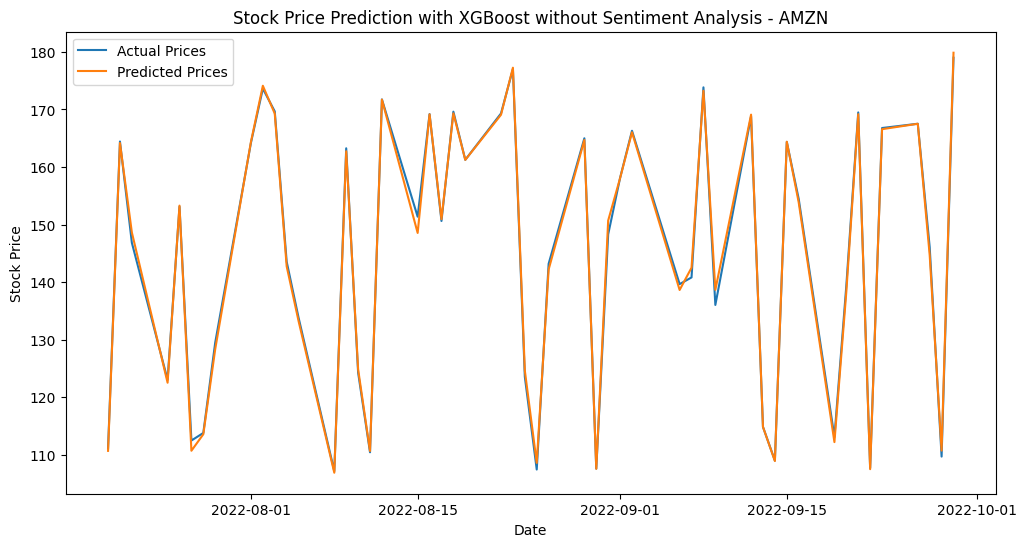

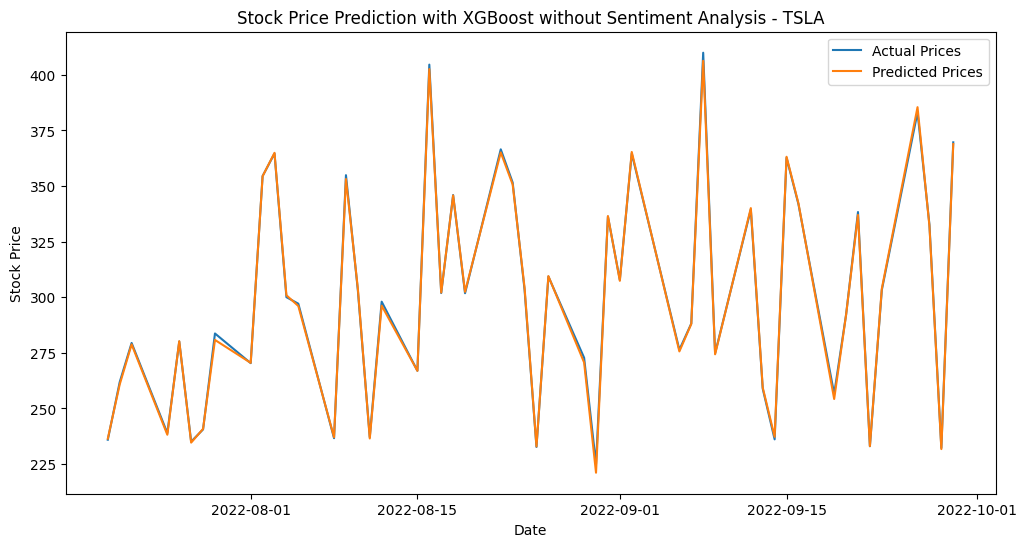

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import xgboost as xgb
import matplotlib.pyplot as plt

merged_data = df_for_training
merged_data_2 = df_for_training_2

X = merged_data[['Open', 'High', 'Low', 'Volume', 'Adj Close' , 'Close']]  # Features
y = merged_data['Close']  # Target variable (stock price)

X_2 = merged_data_2[['Open', 'High', 'Low', 'Volume', 'Adj Close' , 'Close']]  # Features
y_2 = merged_data_2['Close']  # Target variable (stock price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

xgb_model = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model.fit(X_train, y_train)

xgb_model_2 = xgb.XGBRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
xgb_model_2.fit(X_2_train, y_2_train)

predictions = xgb_model.predict(X_test)
predictions_2 = xgb_model_2.predict(X_2_test)
rmse = mean_squared_error(y_test, predictions, squared=False)
rmse_2 = mean_squared_error(y_2_test, predictions_2, squared=False)
print(f"RMSE for AMZN without sentiment analysis: {rmse}")
print(f"RMSE for TSLA without sentiment analysis: {rmse_2}")

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(predictions):], y_test, label='Actual Prices')
plt.plot(merged_data.index[-len(predictions):], predictions, label='Predicted Prices')
plt.title('Stock Price Prediction with XGBoost without Sentiment Analysis - AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data_2.index[-len(predictions_2):], y_2_test, label='Actual Prices')
plt.plot(merged_data_2.index[-len(predictions_2):], predictions_2, label='Predicted Prices')
plt.title('Stock Price Prediction with XGBoost without Sentiment Analysis - TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

RMSE for AMZN without sentiment analysis (SVR): 0.7281034074993227
RMSE for AMZN with sentiment analysis (SVR): 0.08199682282628247


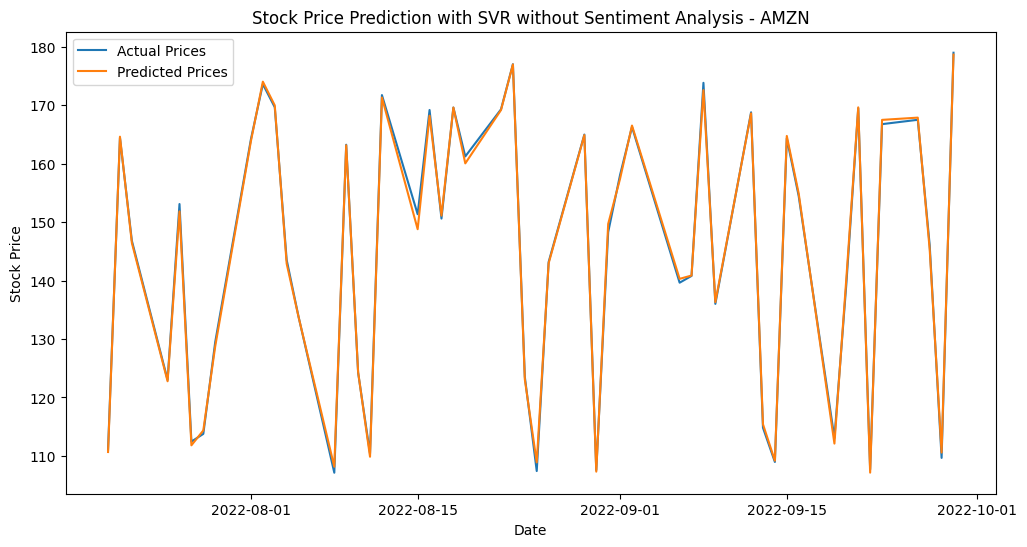

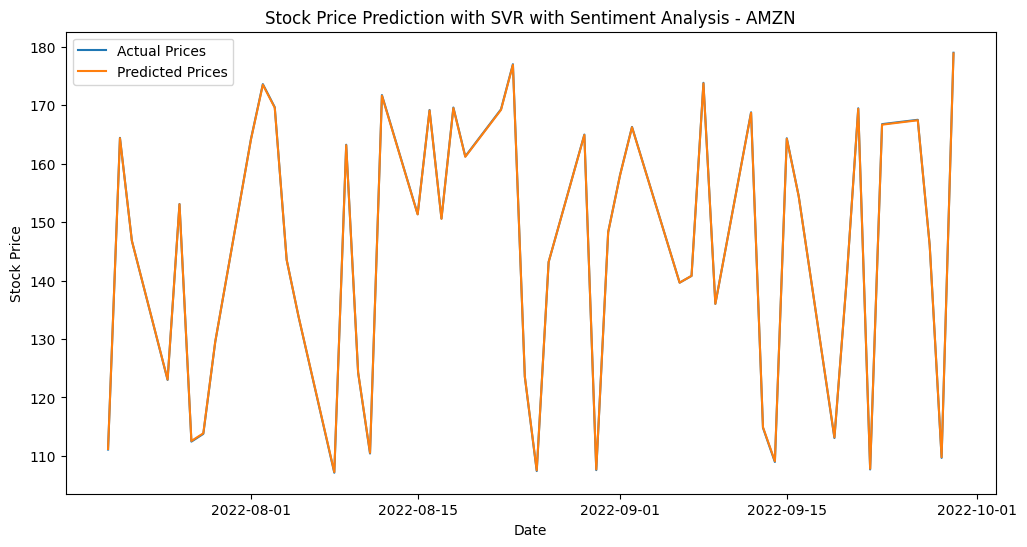

In [ ]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

merged_data = df_for_training

X = merged_data[['Open', 'High', 'Low', 'Volume', 'Adj Close' , 'Close']]  # Features
y = merged_data['Close']  # Target variable (stock price)

X_2 = merged_data[['sentiment_score', 'Close' , 'sentiment_label']]
y_2 = merged_data['Close']  # Target variable (stock price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_2_train)
X_2_train = scaling.transform(X_2_train)
X_2_test = scaling.transform(X_2_test)

svr_model = SVR(kernel='linear')
svr_model.fit(X_train, y_train)

svr_model_2 = SVR(kernel='linear')
svr_model_2.fit(X_2_train, y_2_train)

svr_predictions = svr_model.predict(X_test)
svr_predictions_2 = svr_model_2.predict(X_2_test)

rmse_svr = mean_squared_error(y_test, svr_predictions, squared=False)
rmse_svr_2 = mean_squared_error(y_2_test, svr_predictions_2, squared=False)

print(f"RMSE for AMZN without sentiment analysis (SVR): {rmse_svr}")
print(f"RMSE for AMZN with sentiment analysis (SVR): {rmse_svr_2}")

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(svr_predictions):], y_test, label='Actual Prices')
plt.plot(merged_data.index[-len(svr_predictions):], svr_predictions, label='Predicted Prices')
plt.title('Stock Price Prediction with SVR without Sentiment Analysis - AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(svr_predictions_2):], y_2_test, label='Actual Prices')
plt.plot(merged_data.index[-len(svr_predictions_2):], svr_predictions_2, label='Predicted Prices')
plt.title('Stock Price Prediction with SVR with Sentiment Analysis - AMZN')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


RMSE for TSLA without sentiment analysis (SVR): 3.893377033261168
RMSE for TSLA with sentiment analysis (SVR): 13.1390891298125


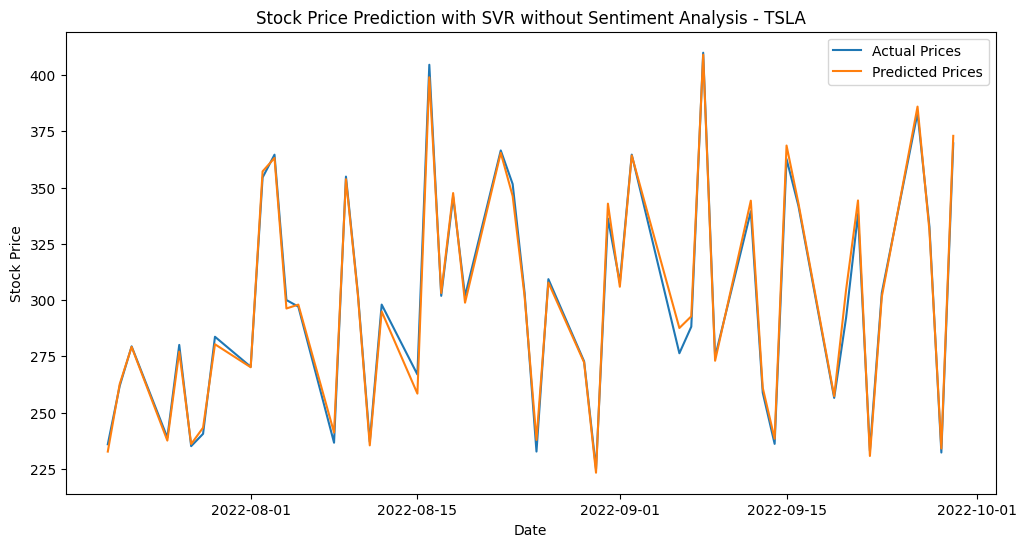

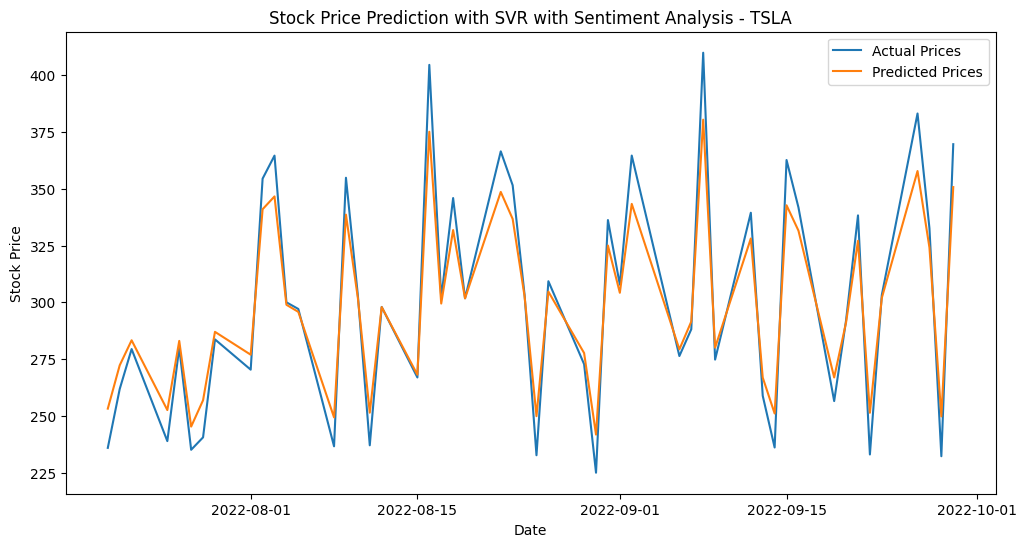

In [ ]:
from sklearn.svm import SVR
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

merged_data = df_for_training_2

X = merged_data[['Open', 'High', 'Low', 'Volume', 'Adj Close' , 'Close']]  # Features
y = merged_data['Close']  # Target variable (stock price)

X_2 = merged_data[['sentiment_score', 'Close' , 'sentiment_label']]
y_2 = merged_data['Close']  # Target variable (stock price)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_train)
X_train = scaling.transform(X_train)
X_test = scaling.transform(X_test)
X_2_train, X_2_test, y_2_train, y_2_test = train_test_split(X_2, y_2, test_size=0.2, random_state=42)
scaling = MinMaxScaler(feature_range=(-1,1)).fit(X_2_train)
X_2_train = scaling.transform(X_2_train)
X_2_test = scaling.transform(X_2_test)

svr_model = SVR(kernel='linear')
svr_model.fit(X_train, y_train)

svr_model_2 = SVR(kernel='linear')
svr_model_2.fit(X_2_train, y_2_train)

svr_predictions = svr_model.predict(X_test)
svr_predictions_2 = svr_model_2.predict(X_2_test)

rmse_svr = mean_squared_error(y_test, svr_predictions, squared=False)
rmse_svr_2 = mean_squared_error(y_2_test, svr_predictions_2, squared=False)

print(f"RMSE for TSLA without sentiment analysis (SVR): {rmse_svr}")
print(f"RMSE for TSLA with sentiment analysis (SVR): {rmse_svr_2}")

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(svr_predictions):], y_test, label='Actual Prices')
plt.plot(merged_data.index[-len(svr_predictions):], svr_predictions, label='Predicted Prices')
plt.title('Stock Price Prediction with SVR without Sentiment Analysis - TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(merged_data.index[-len(svr_predictions_2):], y_2_test, label='Actual Prices')
plt.plot(merged_data.index[-len(svr_predictions_2):], svr_predictions_2, label='Predicted Prices')
plt.title('Stock Price Prediction with SVR with Sentiment Analysis - TSLA')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.show()


Random Forest Regressor
RMSE without sentiment analysis for AMZN:  0.40288885906454963
RMSE with sentiment analysis for AMZN:  0.29289240268457684
R-squared (R2) without sentiment analysis for AMZN:  0.999709417959929
R-squared (R2) with sentiment analysis for AMZN:  0.9998464271423823
XGBoost Regressor
RMSE without sentiment analysis for AMZN:  0.8442256880064515
RMSE with sentiment analysis for AMZN:  0.5597166373864045
R-squared (R2) without sentiment analysis for AMZN:  0.9987241037015395
R-squared (R2) with sentiment analysis for AMZN:  0.9994391655474966
Support Vector Regressor
RMSE without sentiment analysis for AMZN:  22.82978543563787
RMSE with sentiment analysis for AMZN:  11.773659691507662
R-squared (R2) without sentiment analysis for AMZN:  0.06695645696809394
R-squared (R2) with sentiment analysis for AMZN:  0.7518460402514507


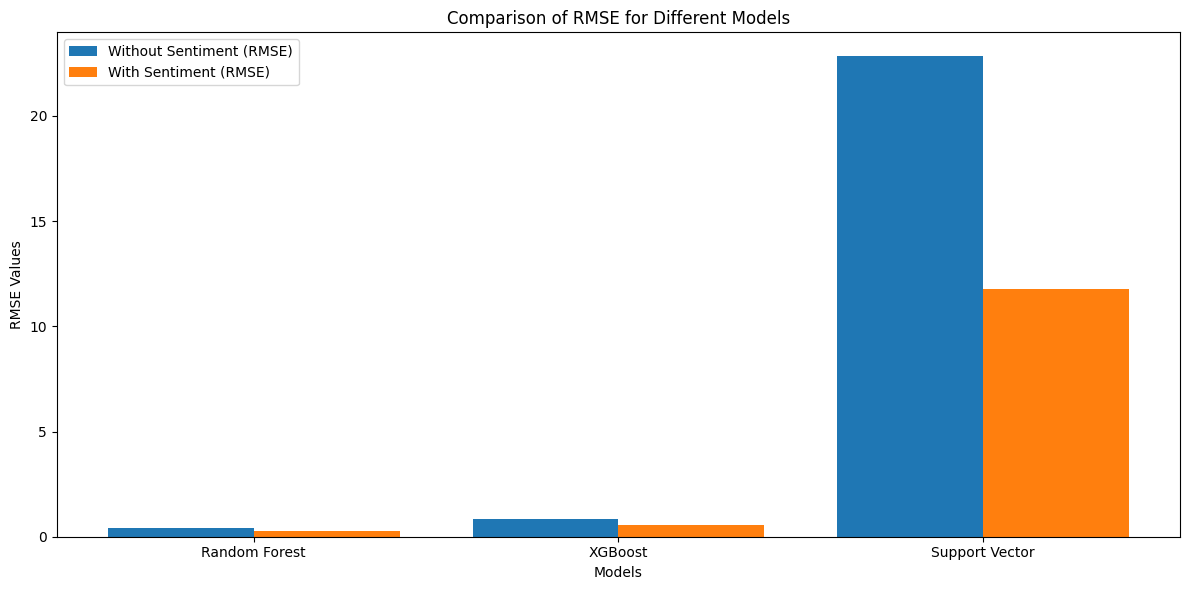

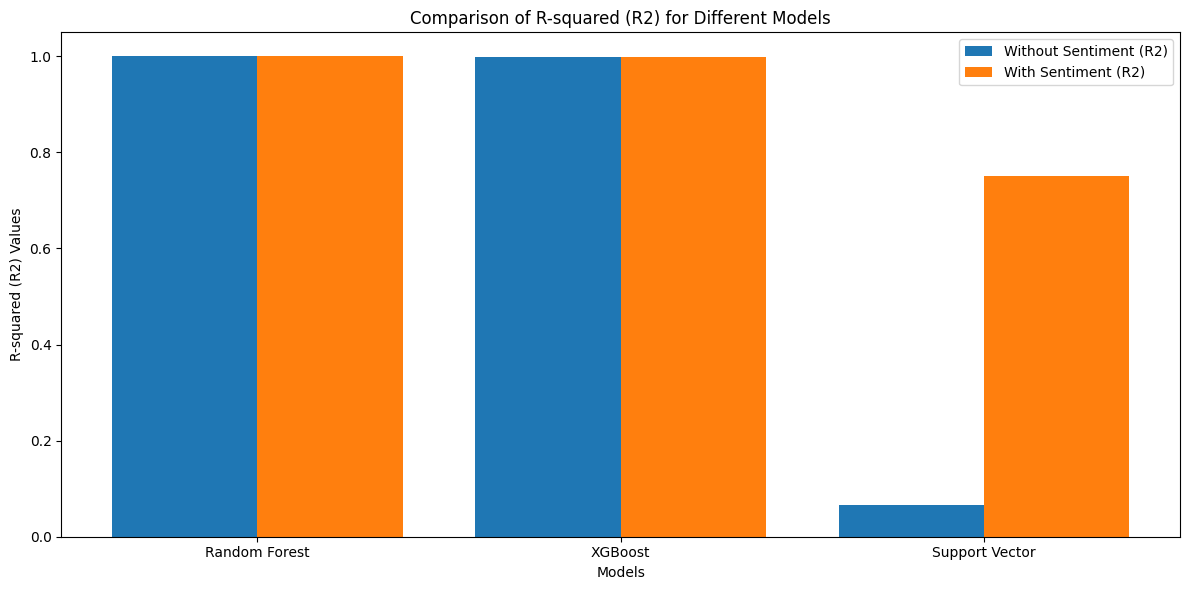

In [ ]:
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

merged_data = df_for_training

X = merged_data[['Open', 'High', 'Low', 'Volume', 'Adj Close', 'Close']]  # Features
y = merged_data['Close']  # Target variable (stock price)

X_2 = merged_data[['sentiment_score', 'Close', 'sentiment_label']]  # Features
y_2 = merged_data['Close']  # Target variable (stock price)

X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X, y, test_size=0.2, random_state=42)
X_train_2, X_test_2, y_train_2, y_test_2 = train_test_split(X_2, y_2, test_size=0.2, random_state=42)

rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train_1, y_train_1)
rf_model_2 = RandomForestRegressor(random_state=42)
rf_model_2.fit(X_train_2, y_train_2)

xgb_model = xgb.XGBRegressor(random_state=42)
xgb_model.fit(X_train_1, y_train_1)
xgb_model_2 = xgb.XGBRegressor(random_state=42)
xgb_model_2.fit(X_train_2, y_train_2)

svr_model = SVR()
svr_model.fit(X_train_1, y_train_1)
svr_model_2 = SVR()
svr_model_2.fit(X_train_2, y_train_2)

rf_predictions = rf_model.predict(X_test_1)
rf_predictions_2 = rf_model_2.predict(X_test_2)
xgb_predictions = xgb_model.predict(X_test_1)
xgb_predictions_2 = xgb_model_2.predict(X_test_2)
svr_predictions = svr_model.predict(X_test_1)
svr_predictions_2 = svr_model_2.predict(X_test_2)

rmse_rf_1 = mean_squared_error(y_test_1, rf_predictions, squared=False)
rmse_rf_2 = mean_squared_error(y_test_2, rf_predictions_2, squared=False)
r2_rf_1 = r2_score(y_test_1, rf_predictions)
r2_rf_2 = r2_score(y_test_2, rf_predictions_2)

rmse_xgb_1 = mean_squared_error(y_test_1, xgb_predictions, squared=False)
rmse_xgb_2 = mean_squared_error(y_test_2, xgb_predictions_2, squared=False)
r2_xgb_1 = r2_score(y_test_1, xgb_predictions)
r2_xgb_2 = r2_score(y_test_2, xgb_predictions_2)

rmse_svr_1 = mean_squared_error(y_test_1, svr_predictions, squared=False)
rmse_svr_2 = mean_squared_error(y_test_2, svr_predictions_2, squared=False)
r2_svr_1 = r2_score(y_test_1, svr_predictions)
r2_svr_2 = r2_score(y_test_2, svr_predictions_2)

print("Random Forest Regressor")
print("RMSE without sentiment analysis for AMZN: ", rmse_rf_1)
print("RMSE with sentiment analysis for AMZN: ", rmse_rf_2)
print("R-squared (R2) without sentiment analysis for AMZN: ", r2_rf_1)
print("R-squared (R2) with sentiment analysis for AMZN: ", r2_rf_2)

print("XGBoost Regressor")
print("RMSE without sentiment analysis for AMZN: ", rmse_xgb_1)
print("RMSE with sentiment analysis for AMZN: ", rmse_xgb_2)
print("R-squared (R2) without sentiment analysis for AMZN: ", r2_xgb_1)
print("R-squared (R2) with sentiment analysis for AMZN: ", r2_xgb_2)

print("Support Vector Regressor")
print("RMSE without sentiment analysis for AMZN: ", rmse_svr_1)
print("RMSE with sentiment analysis for AMZN: ", rmse_svr_2)
print("R-squared (R2) without sentiment analysis for AMZN: ", r2_svr_1)
print("R-squared (R2) with sentiment analysis for AMZN: ", r2_svr_2)


models = ['Random Forest', 'XGBoost', 'Support Vector']
rmse_without_sentiment = [rmse_rf_1, rmse_xgb_1, rmse_svr_1]
rmse_with_sentiment = [rmse_rf_2, rmse_xgb_2, rmse_svr_2]
r2_without_sentiment = [r2_rf_1, r2_xgb_1, r2_svr_1]
r2_with_sentiment = [r2_rf_2, r2_xgb_2, r2_svr_2]
x = np.arange(len(models)) 
width = 0.4 

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width/2, rmse_without_sentiment, width, label='Without Sentiment (RMSE)')
ax.bar(x + width/2, rmse_with_sentiment, width, label='With Sentiment (RMSE)')

ax.set_xlabel('Models')
ax.set_ylabel('RMSE Values')
ax.set_title('Comparison of RMSE for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()

fig, ax = plt.subplots(figsize=(12, 6))

ax.bar(x - width/2, r2_without_sentiment, width, label='Without Sentiment (R2)')
ax.bar(x + width/2, r2_with_sentiment, width, label='With Sentiment (R2)')

ax.set_xlabel('Models')
ax.set_ylabel('R-squared (R2) Values')
ax.set_title('Comparison of R-squared (R2) for Different Models')
ax.set_xticks(x)
ax.set_xticklabels(models)
ax.legend()

plt.tight_layout()
plt.show()